In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import datetime
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from IPython.display import display


def performance_matrics(port_value, output = False):

    #annual volatility
    ann_vol = (port_value.pct_change().std()) * np.sqrt(250)
    port_return = pd.DataFrame(index = port_value.index[:], columns=['Values'])
    port_return['Values'] = port_value.pct_change()

    #cumulative return series & max drawdown, max drawdown duration
    port_cum_series= pd.DataFrame(index = port_return.index[:], 
                                  columns=['CumulativeReturn','WaterMark','Drawdown','Dwn_Duration'])

    for i in range(len(port_return)):
        if i == 0:
            port_cum_series['CumulativeReturn'].iloc[i] = 0
            port_cum_series['WaterMark'].iloc[i] = port_cum_series['CumulativeReturn'].iloc[i]
        else:
            port_cum_series['CumulativeReturn'].iloc[i] = (1 + port_return['Values'].iloc[i]) * (1 + port_cum_series['CumulativeReturn'].iloc[i-1]) - 1
            if port_cum_series['CumulativeReturn'].iloc[i] > port_cum_series['WaterMark'].iloc[i-1]:
                port_cum_series['WaterMark'].iloc[i] = port_cum_series['CumulativeReturn'].iloc[i]
            else:
                port_cum_series['WaterMark'].iloc[i] = port_cum_series['WaterMark'].iloc[i-1]  

        port_cum_series['Drawdown'].iloc[i] = ((1 + port_cum_series['WaterMark'].iloc[i]) - (1 + port_cum_series['CumulativeReturn'].iloc[i])) / (1 + port_cum_series['WaterMark'].iloc[i])
        if i == 0:
            port_cum_series['Dwn_Duration'].iloc[i] = 0
        else:
            if port_cum_series['Drawdown'].iloc[i] != 0:
                port_cum_series['Dwn_Duration'].iloc[i] = port_cum_series['Dwn_Duration'].iloc[i-1] + 1
            else:
                port_cum_series['Dwn_Duration'].iloc[i] = 0 


    max_drawdown = port_cum_series['Drawdown'].max()
    max_dwn_duration = port_cum_series['Dwn_Duration'].max()
    total_return = port_value.iloc[-1]/port_value.iloc[0] - 1 
    
    #annual return
    ann_return = (1 + total_return) ** (1 / float((len(port_value)) / 250.0)) - 1 

    #sharpe ratio
    sharpe_ratio = (ann_return) / ann_vol

    print('annual volatility:{}'.format(ann_vol.iloc[0]))
    print('annual return:{}'.format(ann_return.iloc[0]))
    print('sharpe ratio:{}'.format(sharpe_ratio.iloc[0]))
    print('max drawdown:{}'.format(max_drawdown))
    print('max down duration:{} days'.format(max_dwn_duration))
    


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  56013692235
最終 :  165455186288
TW_pos
初始 :  2100000000000
最終 :  3154317195376
TW_bond
初始 :  600000000000
最終 :  3487797419945
tatal
初始total :  4500000000000
最終total :  11693626907885
買進次數 :  0
賣出次數 :  7
總交易次數 :  7
tatal value 在國外投資上限 45.0 %下的表現評估 : 
annual volatility:0.10210331920287918
annual return:0.1059363878079711
sharpe ratio:1.0375410773618006
max drawdown:0.1482160381972862
max down duration:258 days


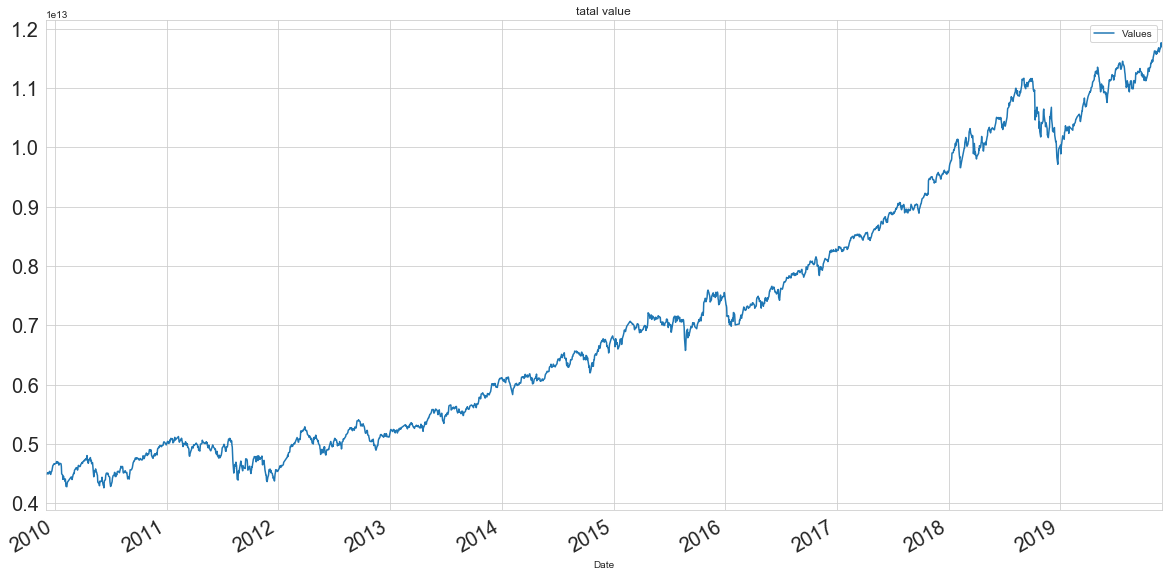

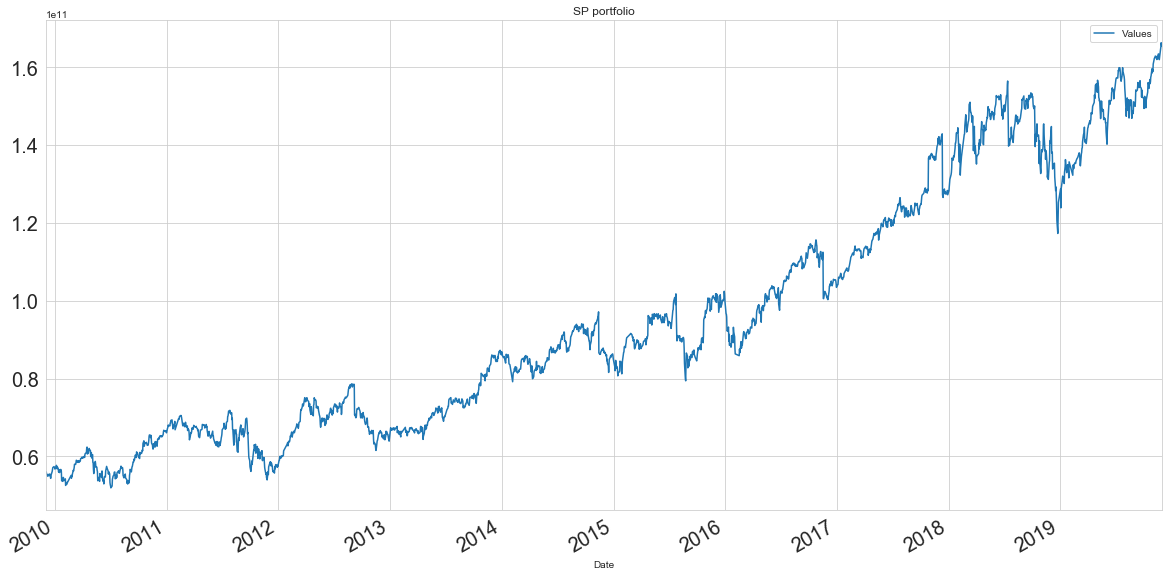

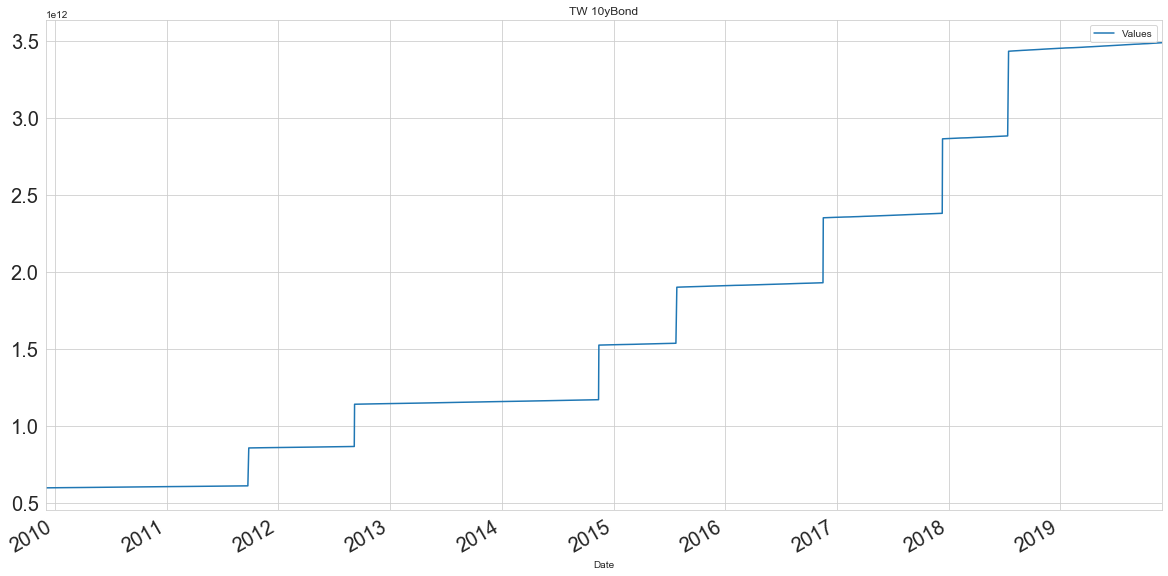

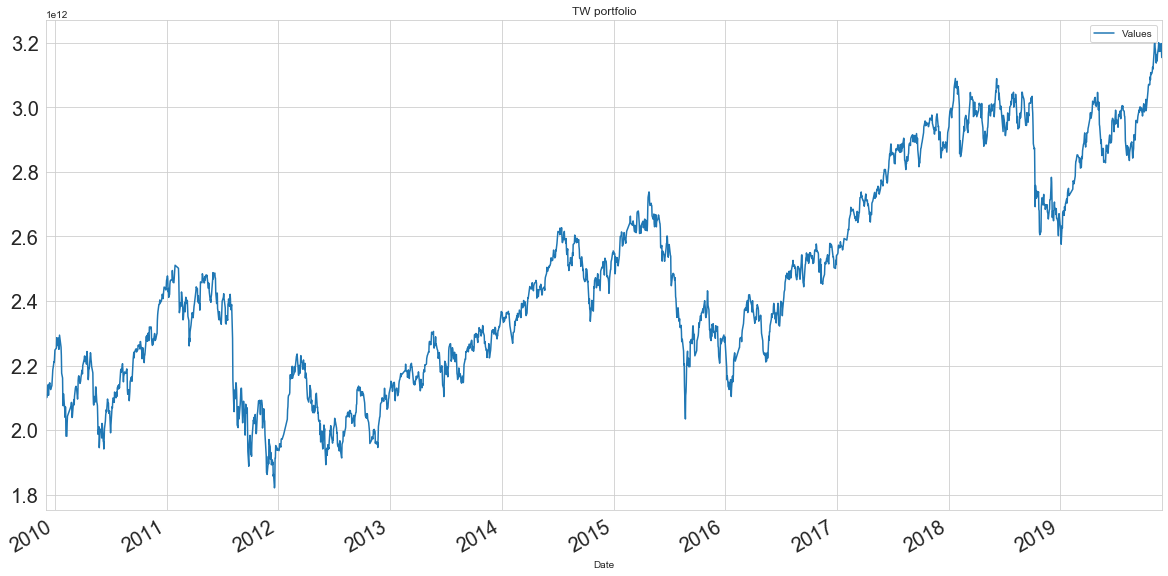

In [2]:
ticker_SP = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG']###公司名稱

daily_SP = pd.read_excel('s_ptop6_stock.xlsx', index_col = 0, header = [0, 1]) ###讀資料
daily_SP.fillna(method = 'ffill', inplace = True)
daily_TW = pd.read_excel('TWII.xlsx', index_col = 0)
daily_TW.fillna(method = 'ffill', inplace = True)
currency=pd.read_excel('USD_TWD historical data.xlsx', index_col = 0)

initial=4500000000000 ###初始資金
limit_SP=0.40  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  63015403765
最終 :  200770041421
TW_pos
初始 :  2100000000000
最終 :  3154317195376
TW_bond
初始 :  375000000000
最終 :  3339766155808
tatal
初始total :  4500000000000
最終total :  12623793485816
買進次數 :  0
賣出次數 :  7
總交易次數 :  7
tatal value 在國外投資上限 50.0 %下的表現評估 : 
annual volatility:0.10952059127326869
annual return:0.11489781972338098
sharpe ratio:1.0490978763682473
max drawdown:0.15089587051089476
max down duration:250 days


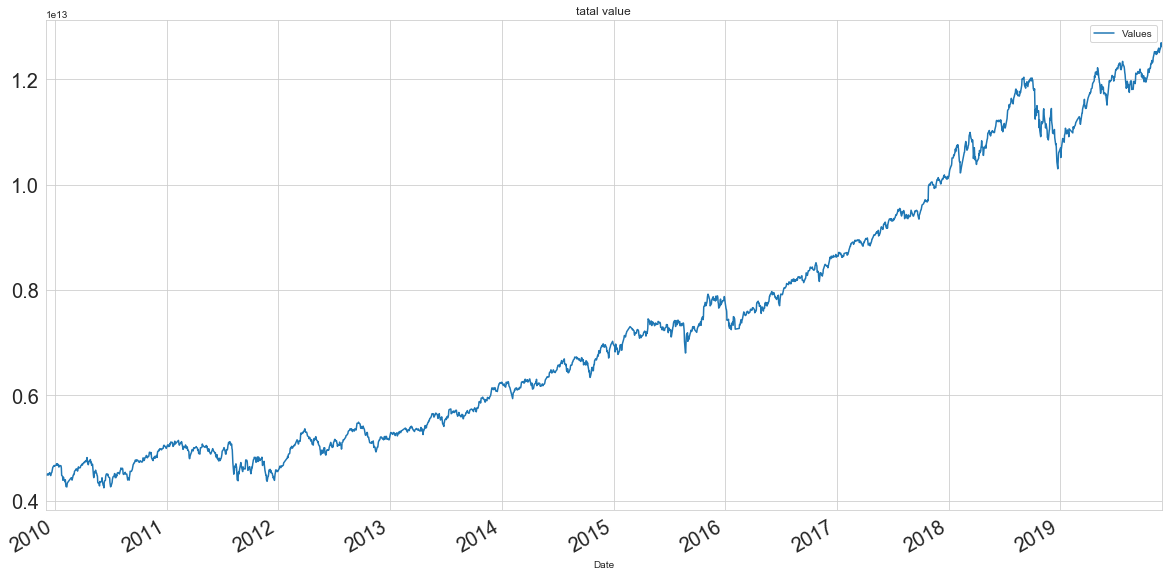

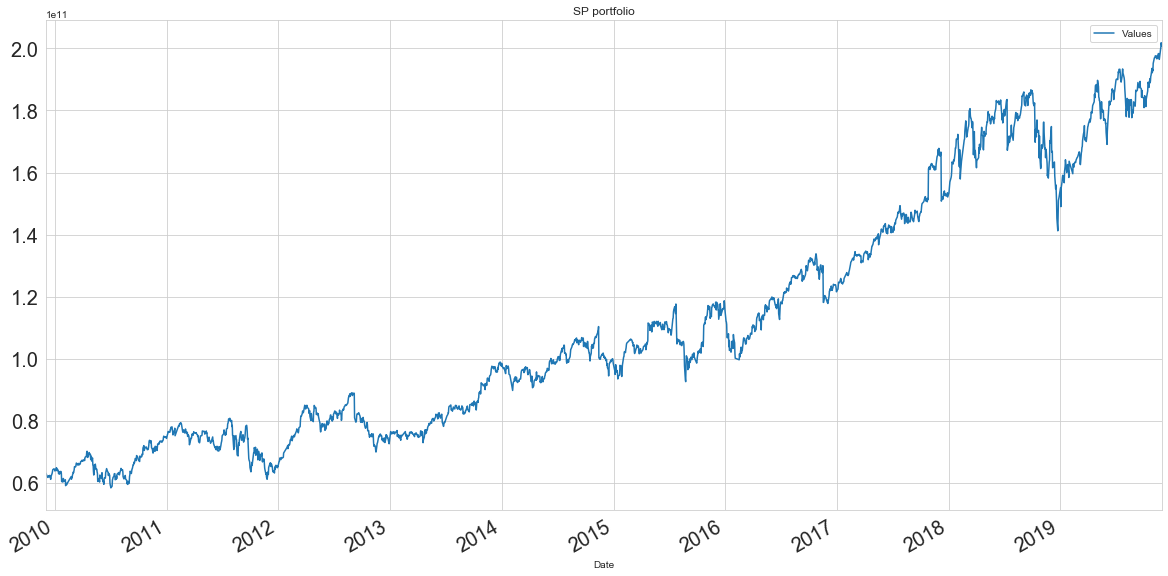

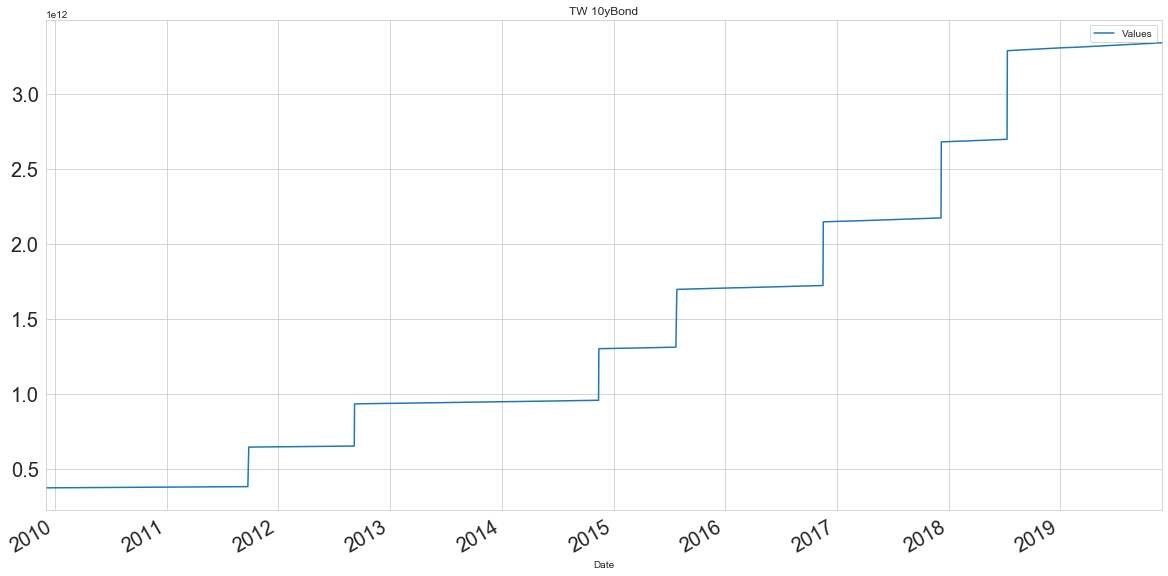

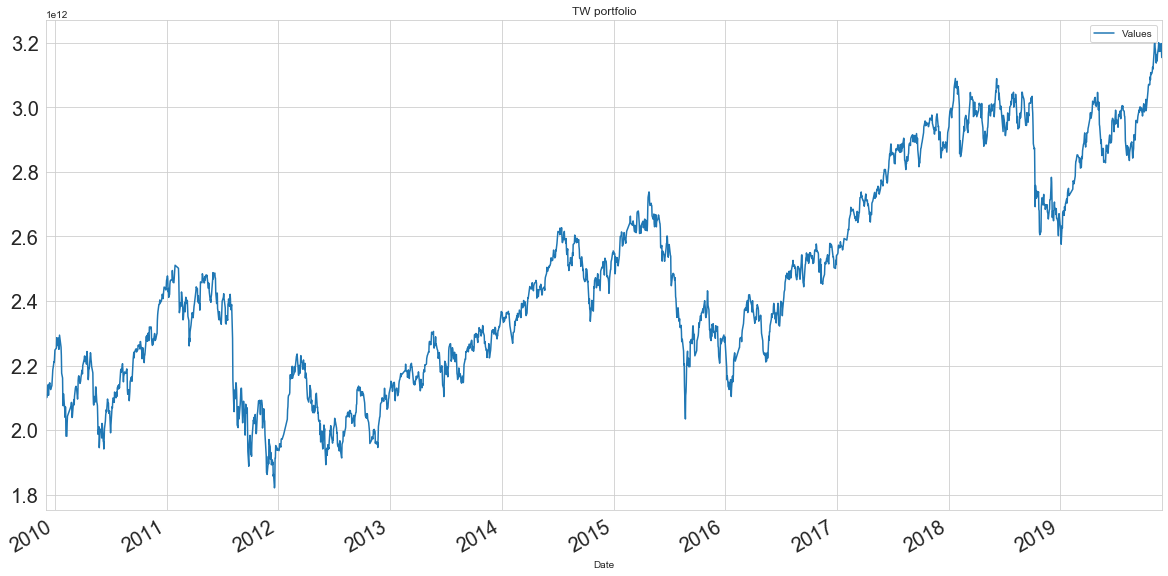

In [3]:
initial=4500000000000 ###初始資金
limit_SP=0.45  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  70017115294
最終 :  234949035782
TW_pos
初始 :  2100000000000
最終 :  3154317195376
TW_bond
初始 :  150000000000
最終 :  3291388936824
tatal
初始total :  4500000000000
最終total :  13618935143683
買進次數 :  0
賣出次數 :  7
總交易次數 :  7
tatal value 在國外投資上限 55.00000000000001 %下的表現評估 : 
annual volatility:0.11692820624114296
annual return:0.12385345088751887
sharpe ratio:1.0592264678386827
max drawdown:0.1551902398900128
max down duration:249 days


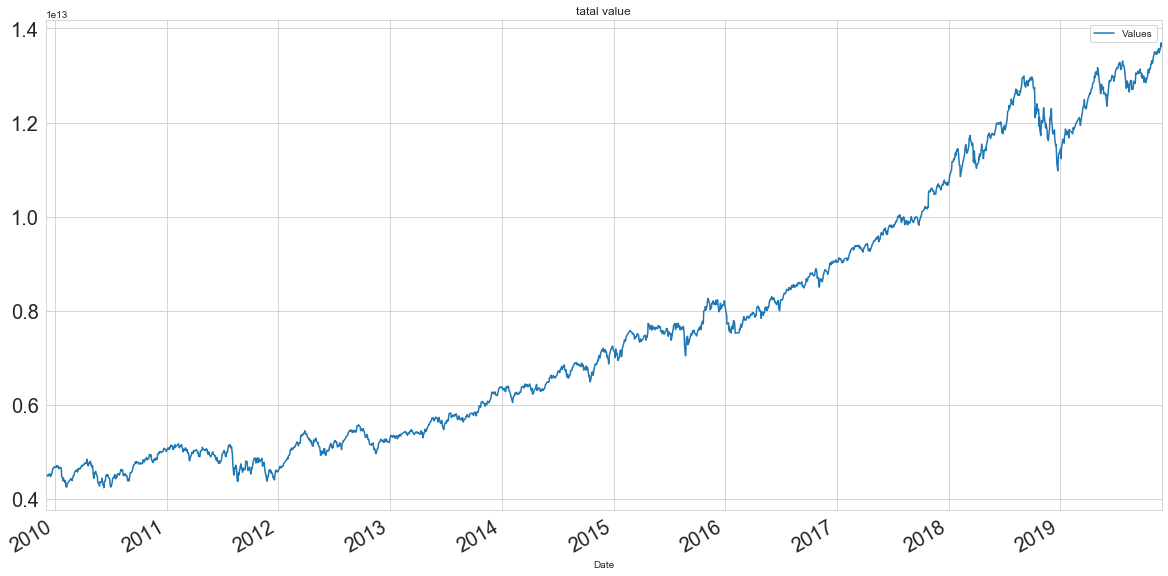

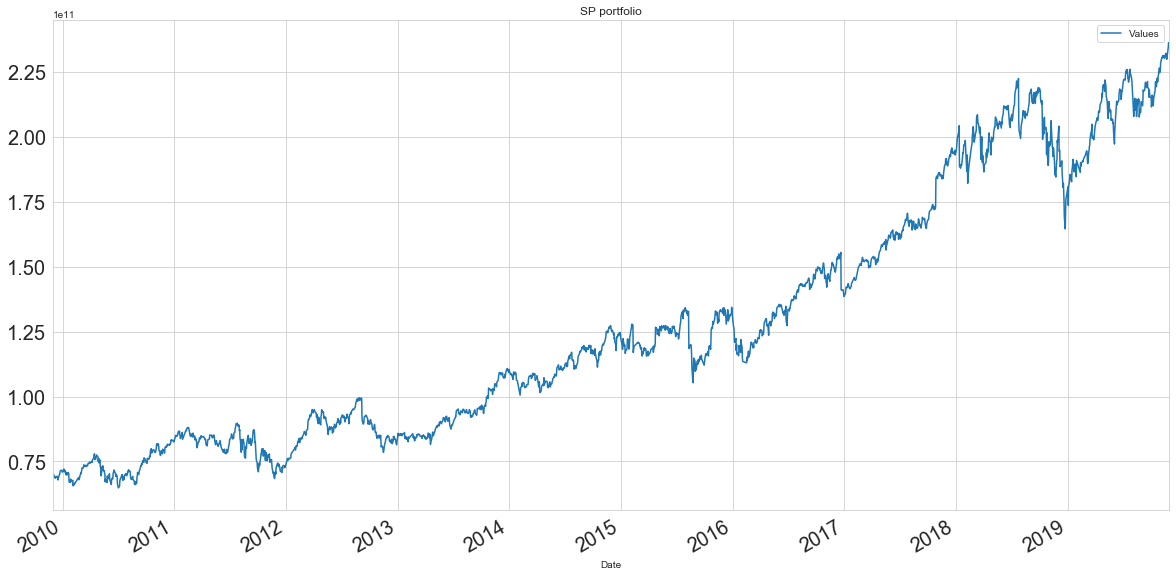

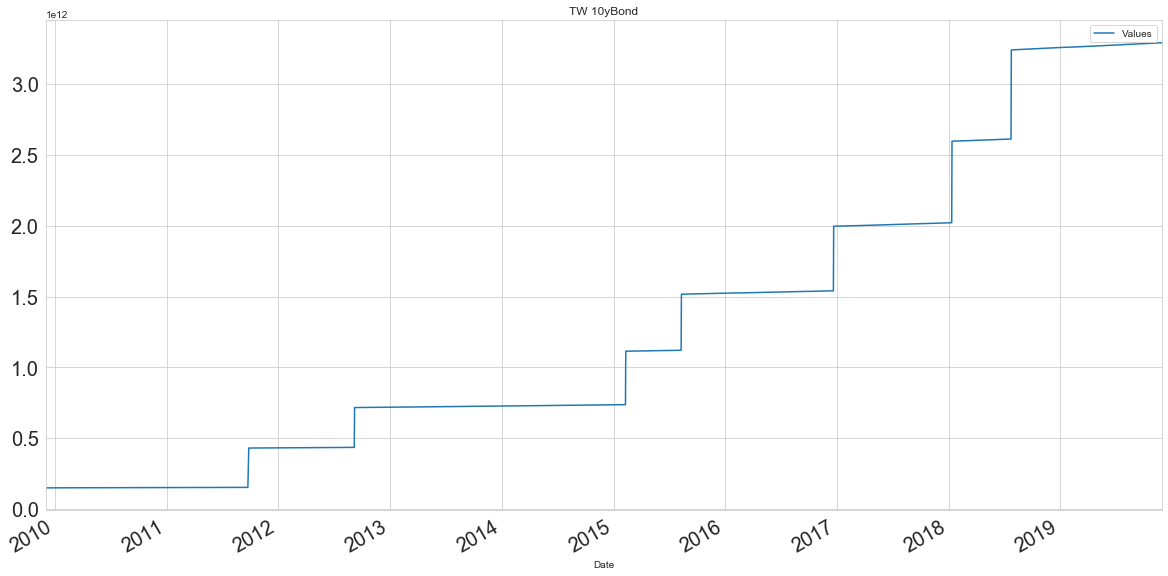

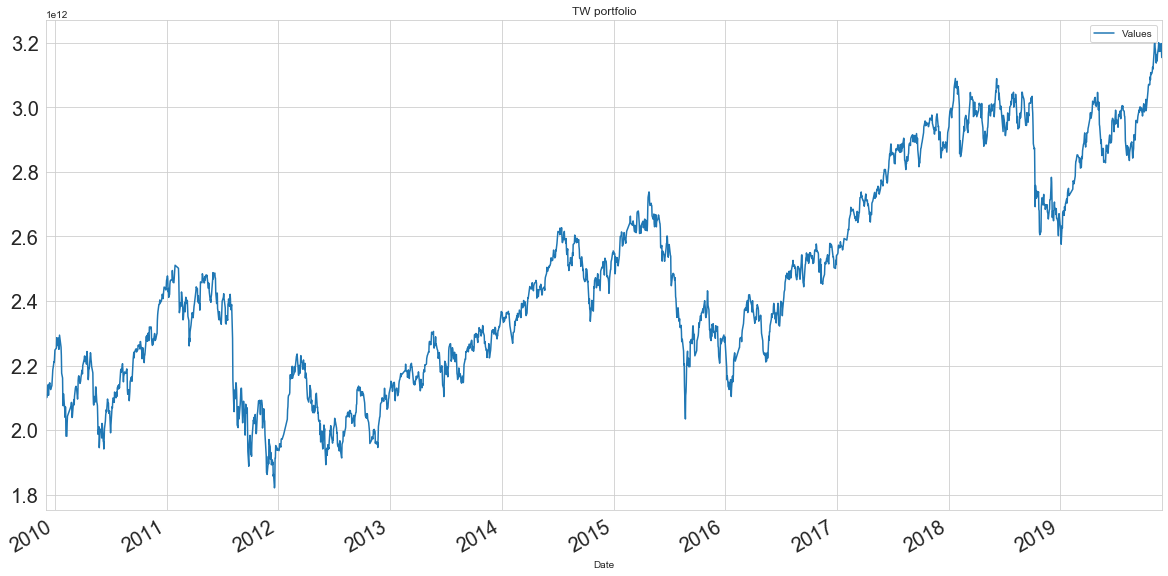

In [4]:
initial=4500000000000 ###初始資金
limit_SP=0.50  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  77018826824
最終 :  279452575050
TW_pos
初始 :  2024999999999
最終 :  3041663009826
TW_bond
初始 :  0
最終 :  2797273770288
tatal
初始total :  4500000000000
最終total :  14370903348970
買進次數 :  0
賣出次數 :  6
總交易次數 :  6
tatal value 在國外投資上限 60.00000000000001 %下的表現評估 : 
annual volatility:0.125044884054208
annual return:0.13024024419907532
sharpe ratio:1.0415479624309547
max drawdown:0.17364960979444624
max down duration:249 days


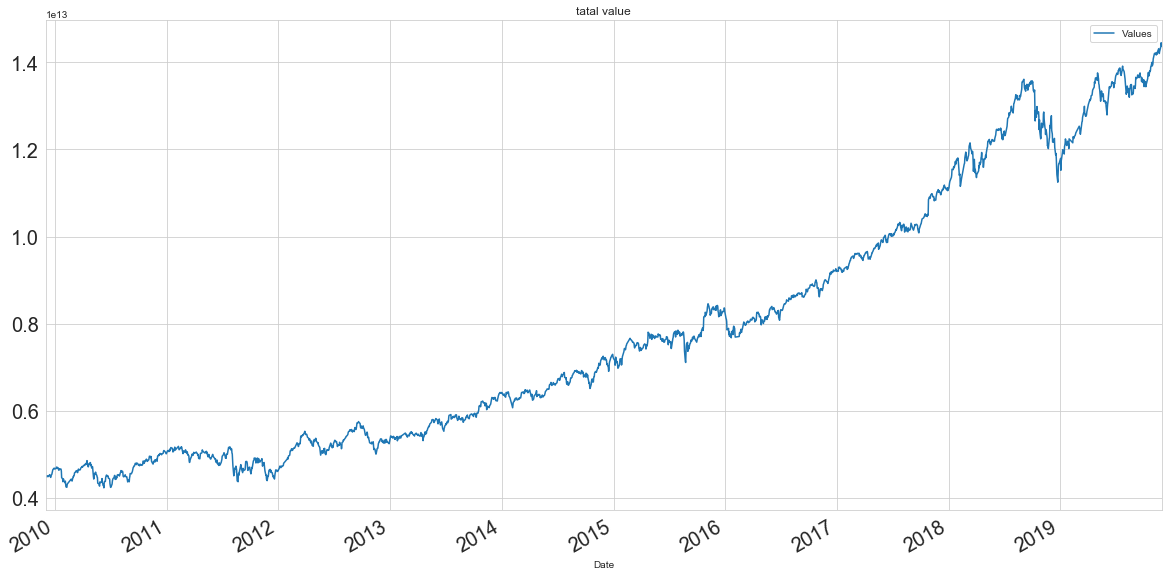

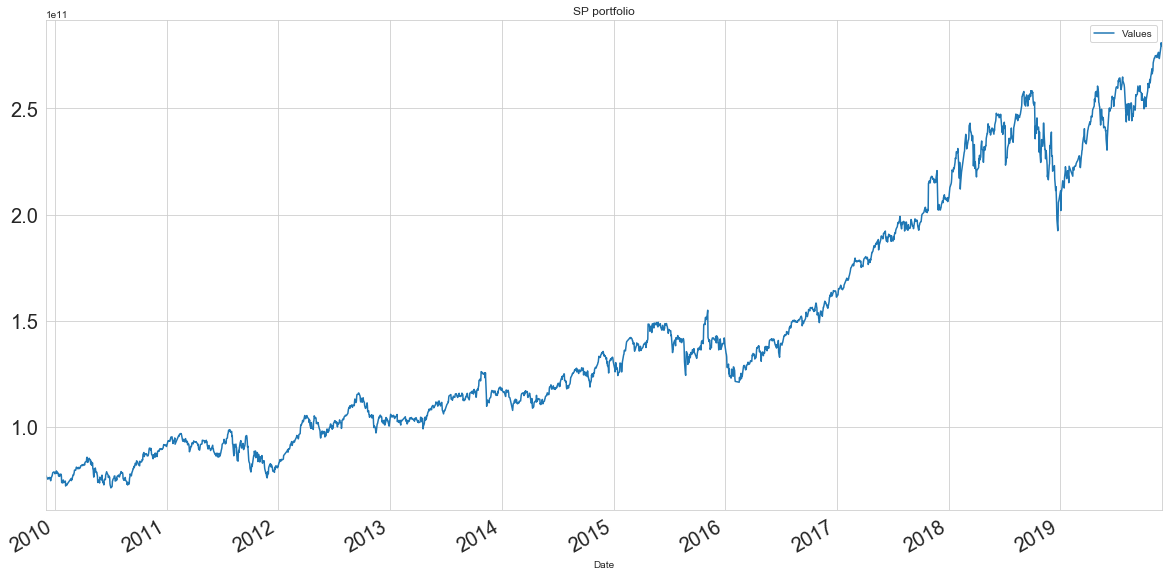

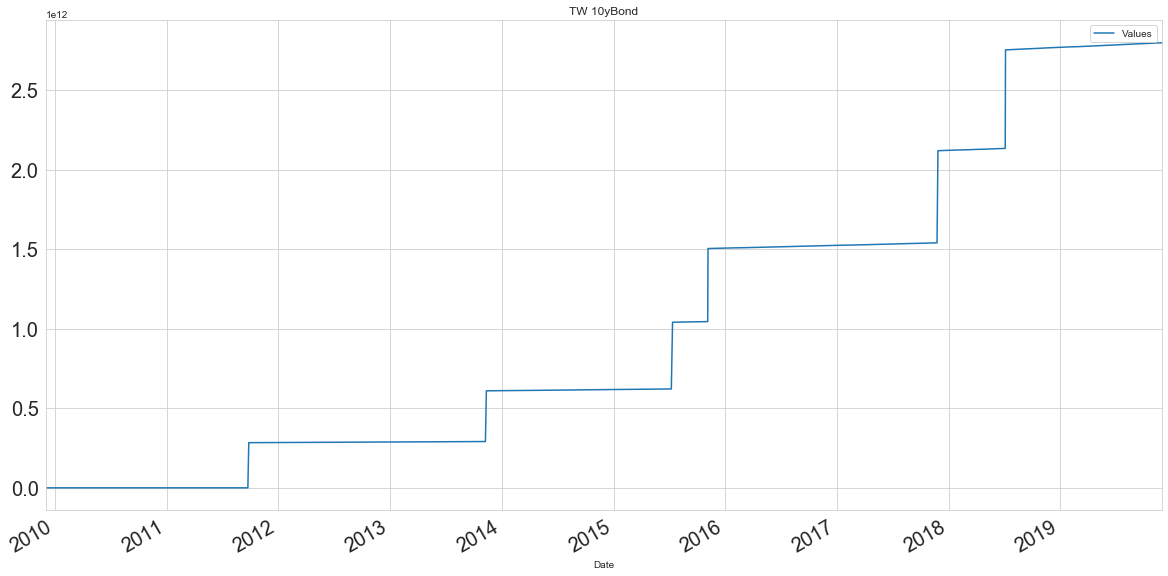

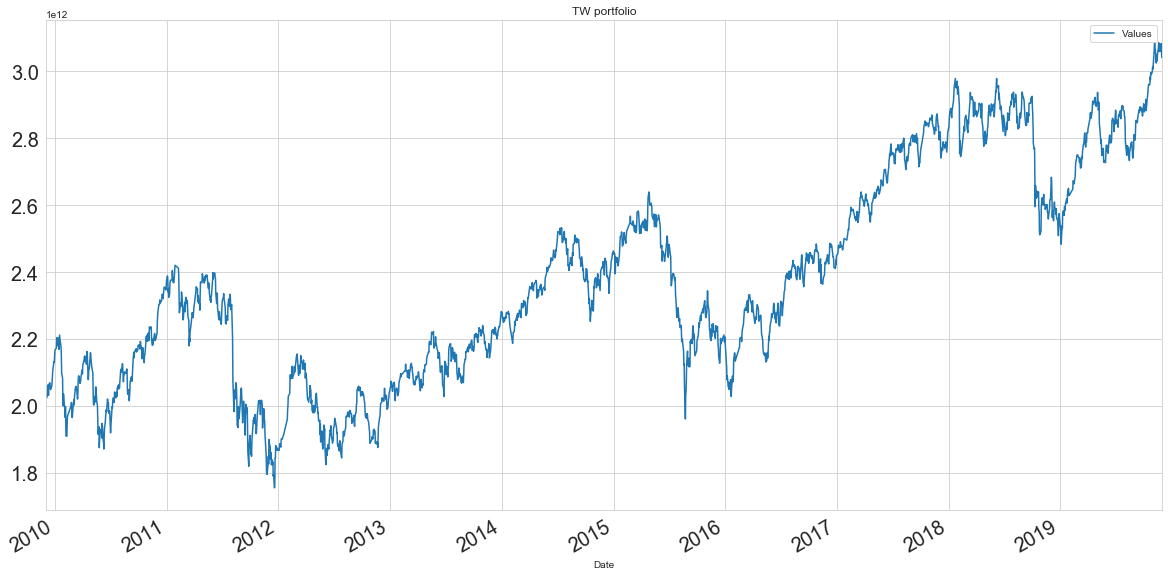

In [5]:
initial=4500000000000 ###初始資金
limit_SP=0.55  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  84020538353
最終 :  319210028408
TW_pos
初始 :  1800000000000
最終 :  2703700453179
TW_bond
初始 :  0
最終 :  2833500348327
tatal
初始total :  4500000000000
最終total :  15283002178843
買進次數 :  0
賣出次數 :  6
總交易次數 :  6
tatal value 在國外投資上限 65.0 %下的表現評估 : 
annual volatility:0.13048780390475698
annual return:0.13759750111896518
sharpe ratio:1.0544855304592111
max drawdown:0.1834972089811774
max down duration:158 days


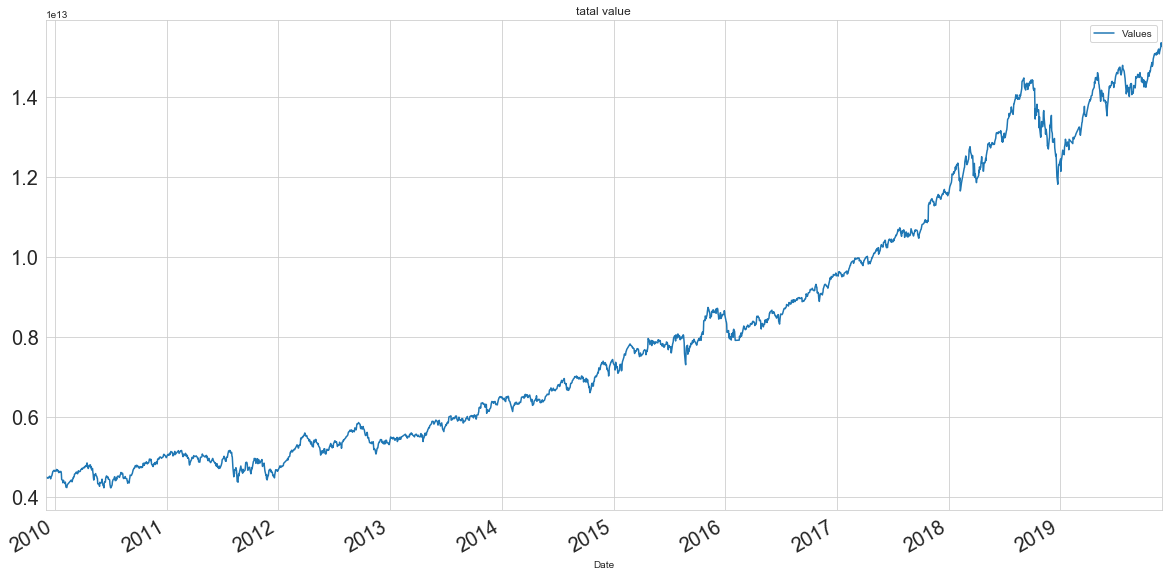

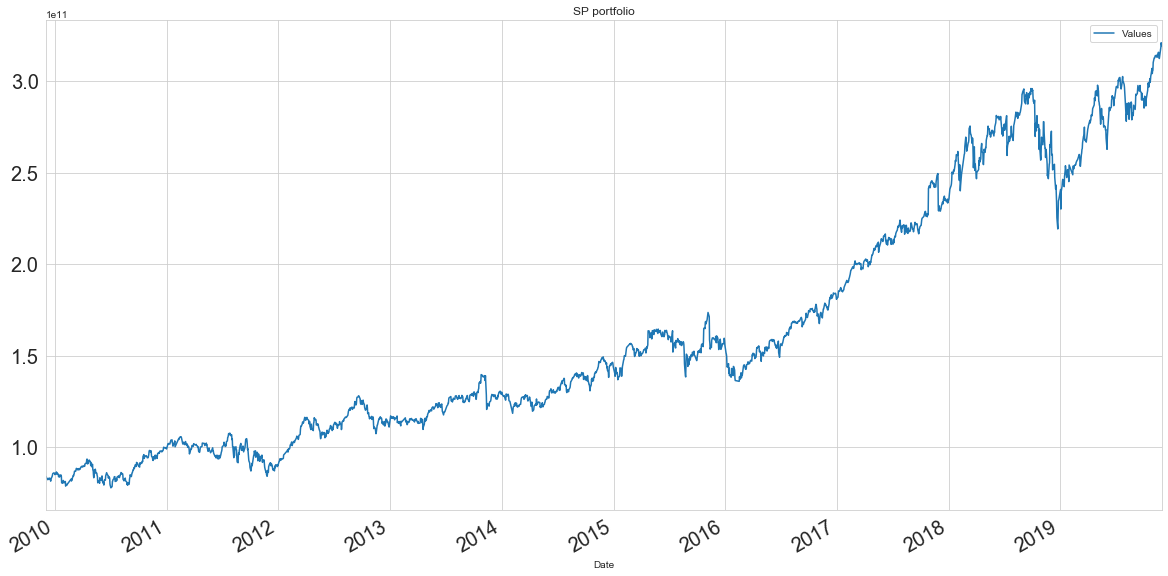

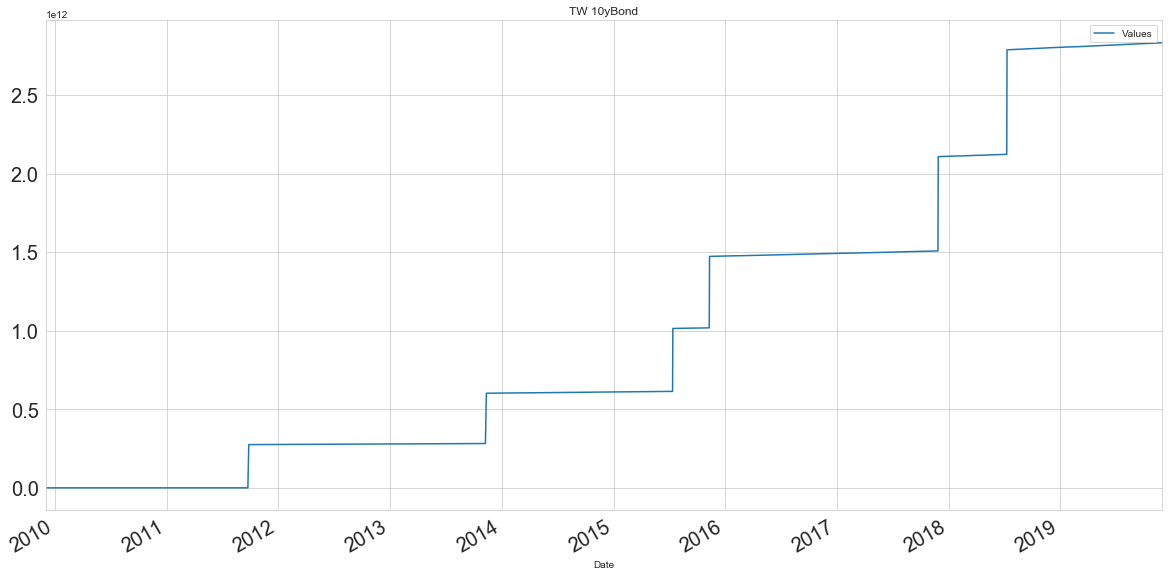

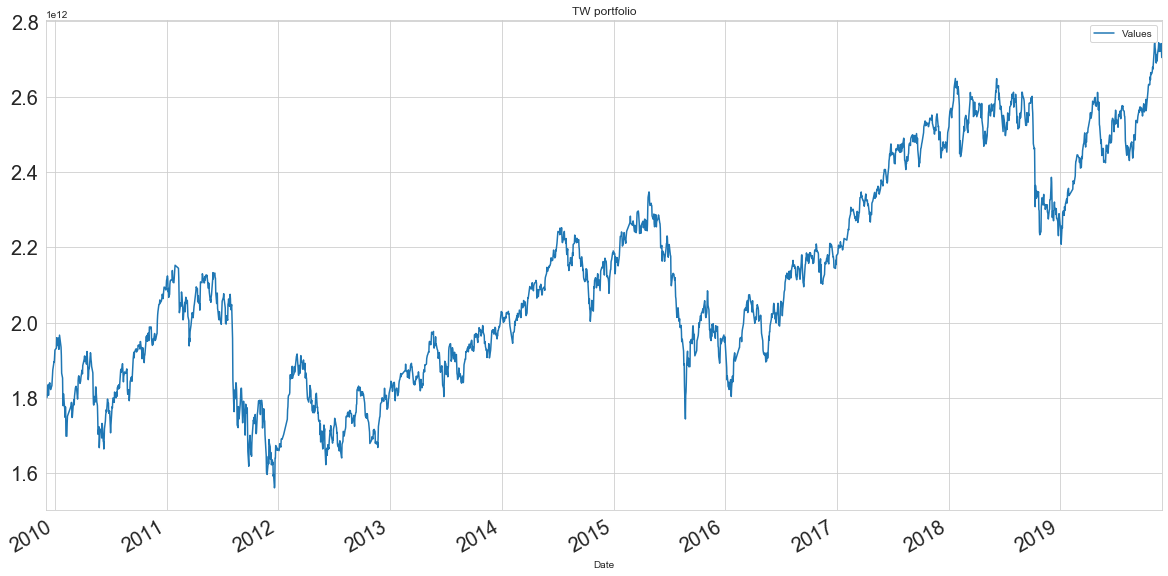

In [6]:
initial=4500000000000 ###初始資金
limit_SP=0.60  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  91022249883
最終 :  357173433516
TW_pos
初始 :  1575000000000
最終 :  2365737896532
TW_bond
初始 :  0
最終 :  3062181499102
tatal
初始total :  4500000000000
最終total :  16332781494329
買進次數 :  0
賣出次數 :  6
總交易次數 :  6
tatal value 在國外投資上限 70.0 %下的表現評估 : 
annual volatility:0.13661999594937402
annual return:0.14559405322073027
sharpe ratio:1.065686265096082
max drawdown:0.189403469789416
max down duration:158 days


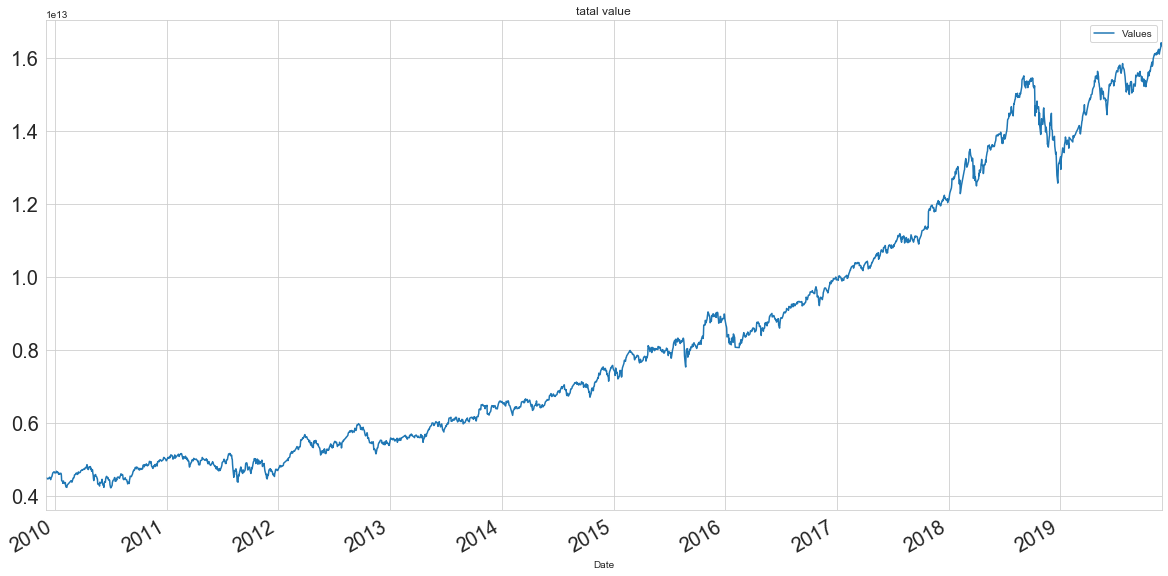

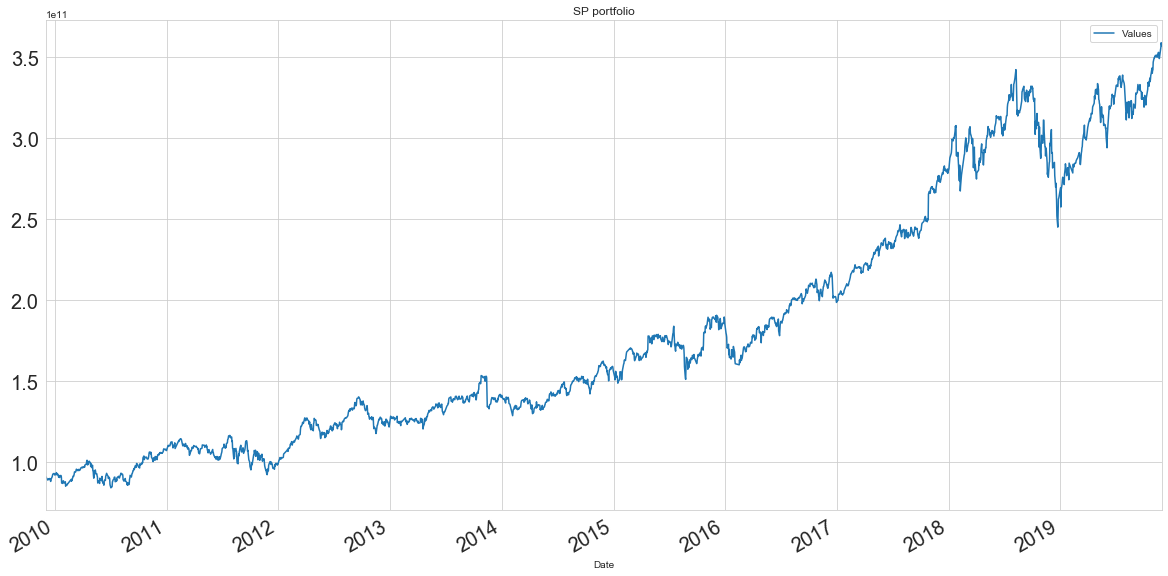

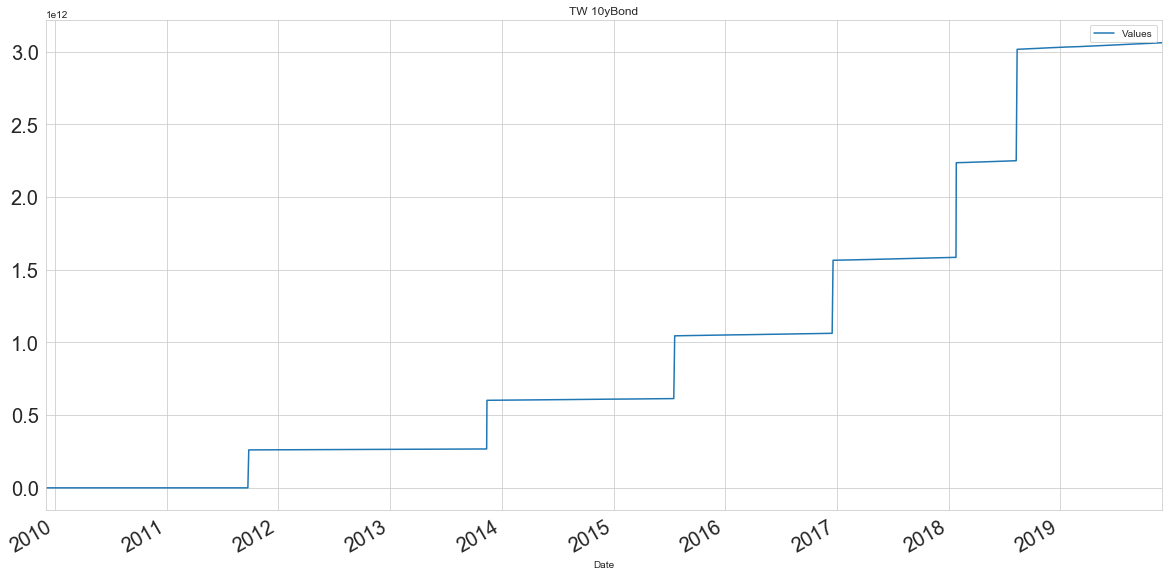

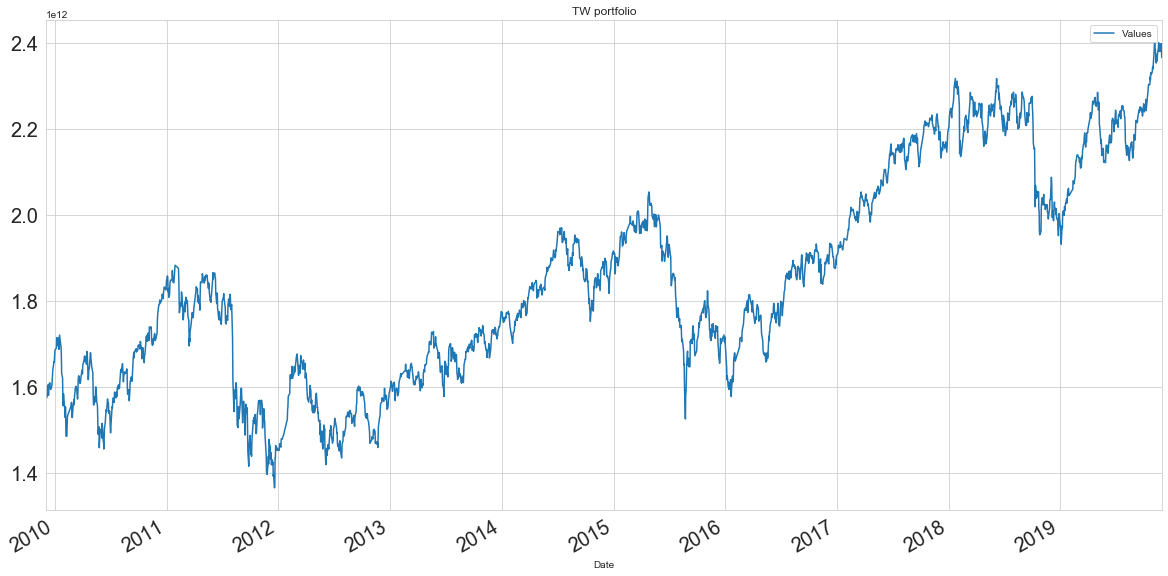

In [7]:
initial=4500000000000 ###初始資金
limit_SP=0.65  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  98023961412
最終 :  429783040226
TW_pos
初始 :  1350000000000
最終 :  2027775339884
TW_bond
初始 :  0
最終 :  3457510428166
tatal
初始total :  4500000000000
最終total :  18606991769197
買進次數 :  1
賣出次數 :  7
總交易次數 :  8
tatal value 在國外投資上限 75.0 %下的表現評估 : 
annual volatility:0.1441069101653945
annual return:0.16144964357352998
sharpe ratio:1.1203462997591915
max drawdown:0.20594574094564125
max down duration:166 days


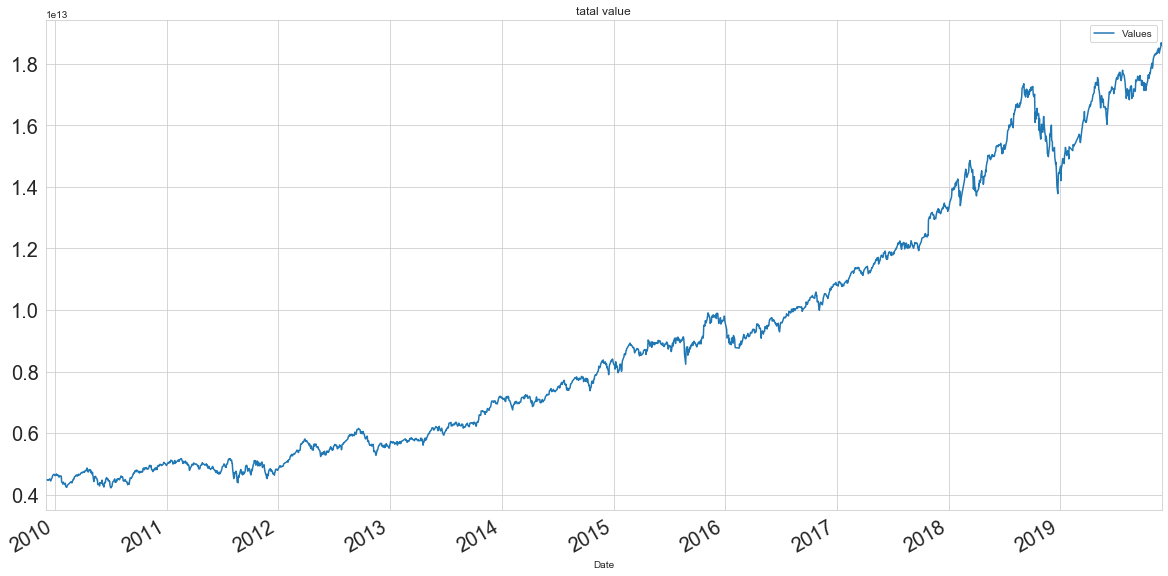

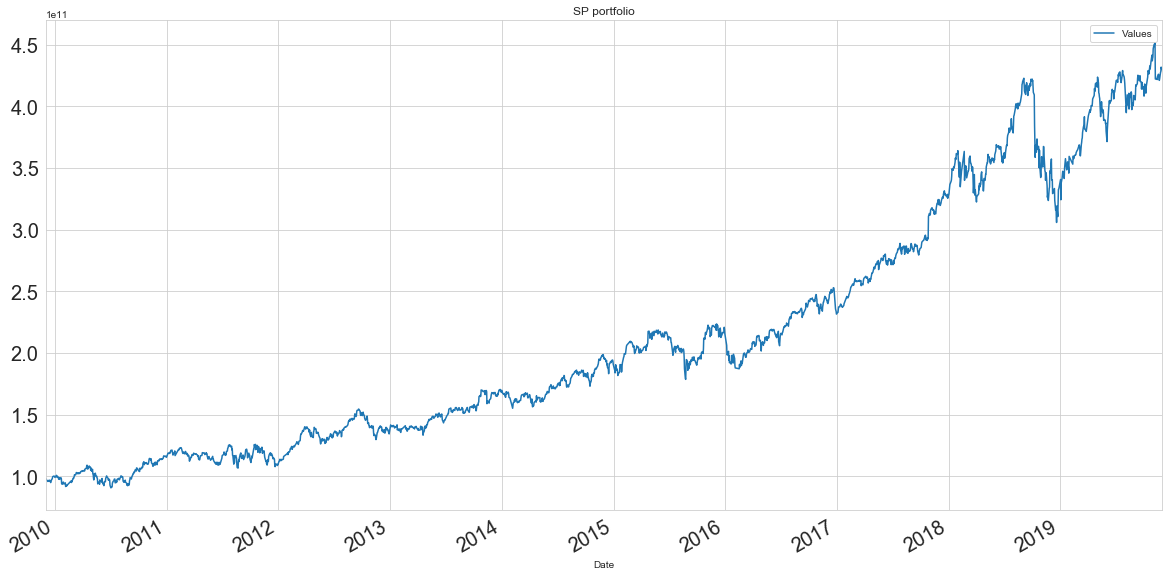

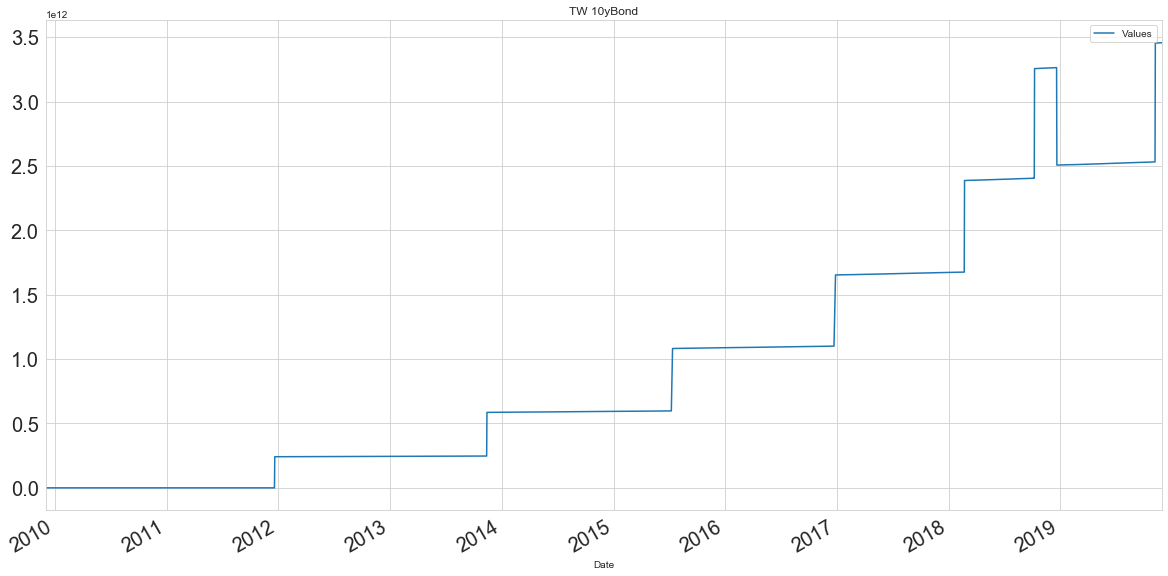

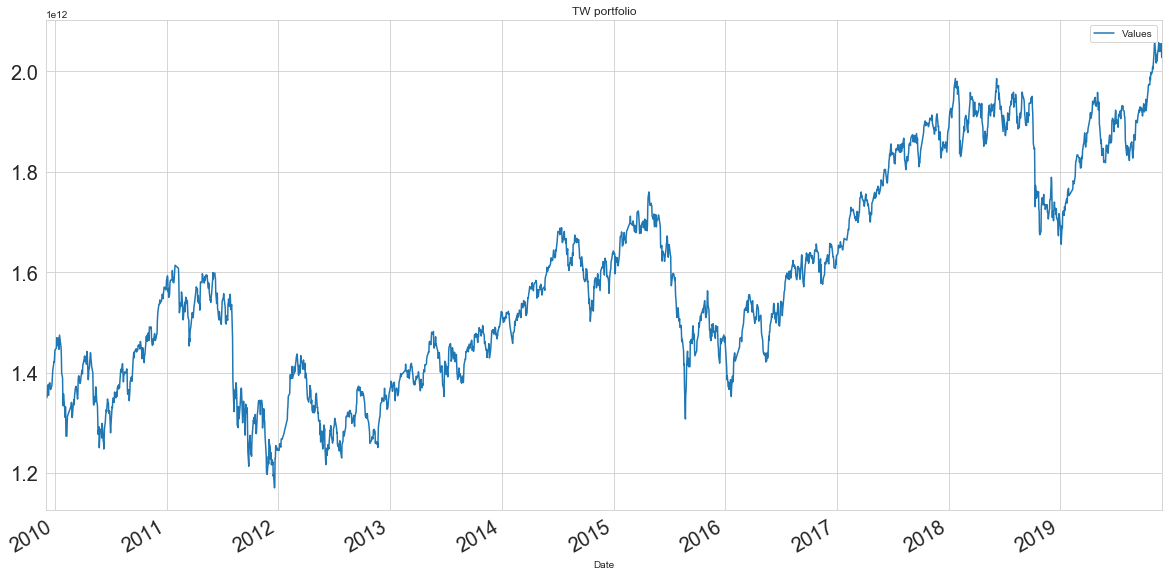

In [8]:
initial=4500000000000 ###初始資金
limit_SP=0.70  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  105025672942
最終 :  485048131512
TW_pos
初始 :  1125000000000
最終 :  1689812783237
TW_bond
初始 :  0
最終 :  3010776988485
tatal
初始total :  4500000000000
最終total :  19509594274925
買進次數 :  0
賣出次數 :  5
總交易次數 :  5
tatal value 在國外投資上限 80.0 %下的表現評估 : 
annual volatility:0.1516193855839619
annual return:0.16726515065824255
sharpe ratio:1.1031910597317156
max drawdown:0.23283027989844904
max down duration:229 days


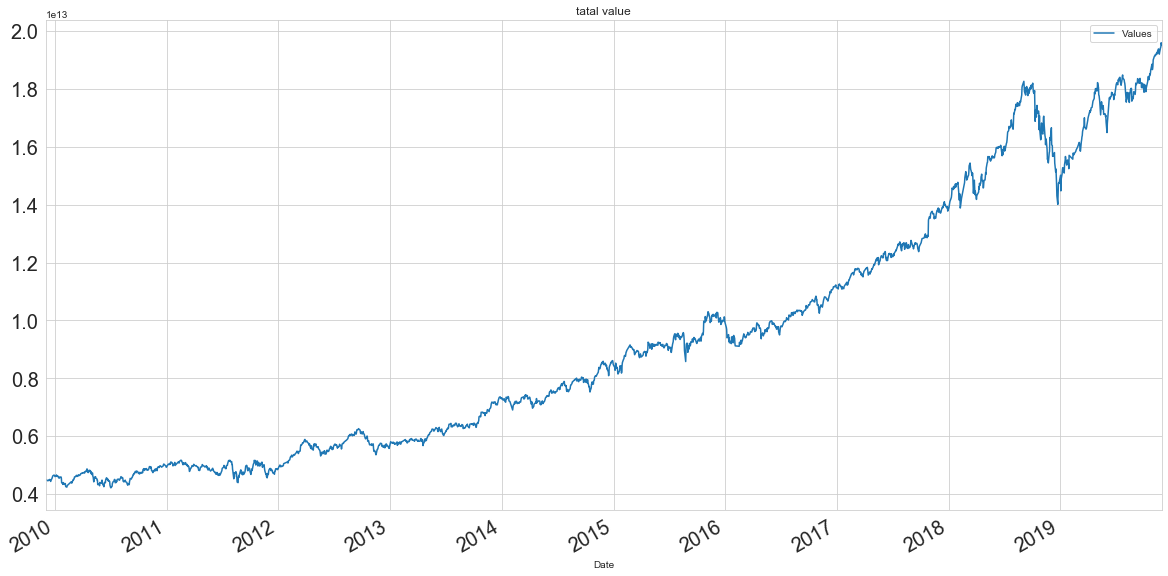

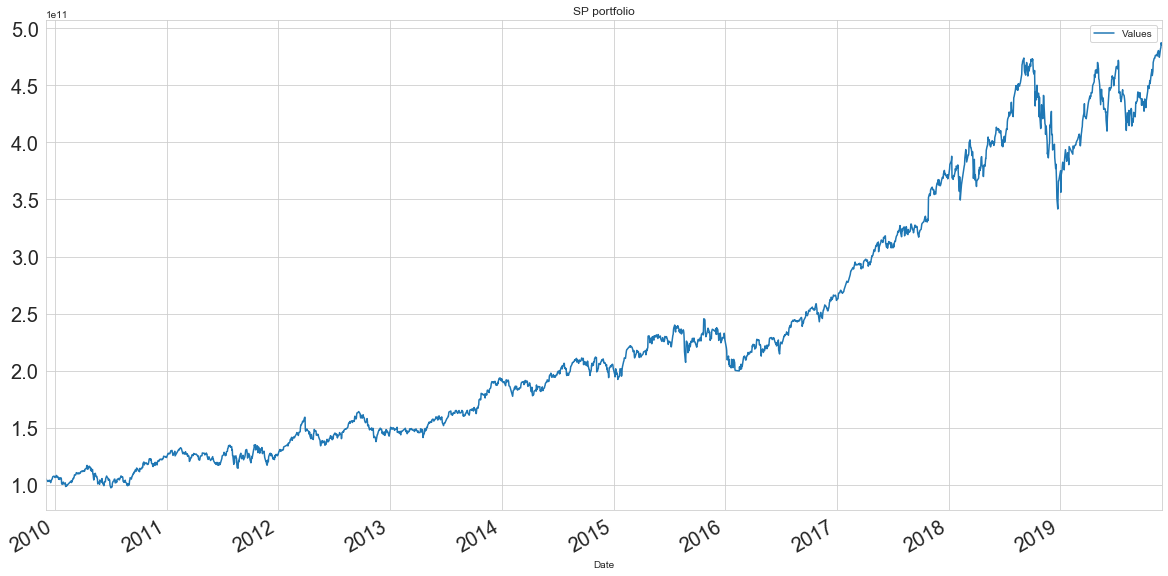

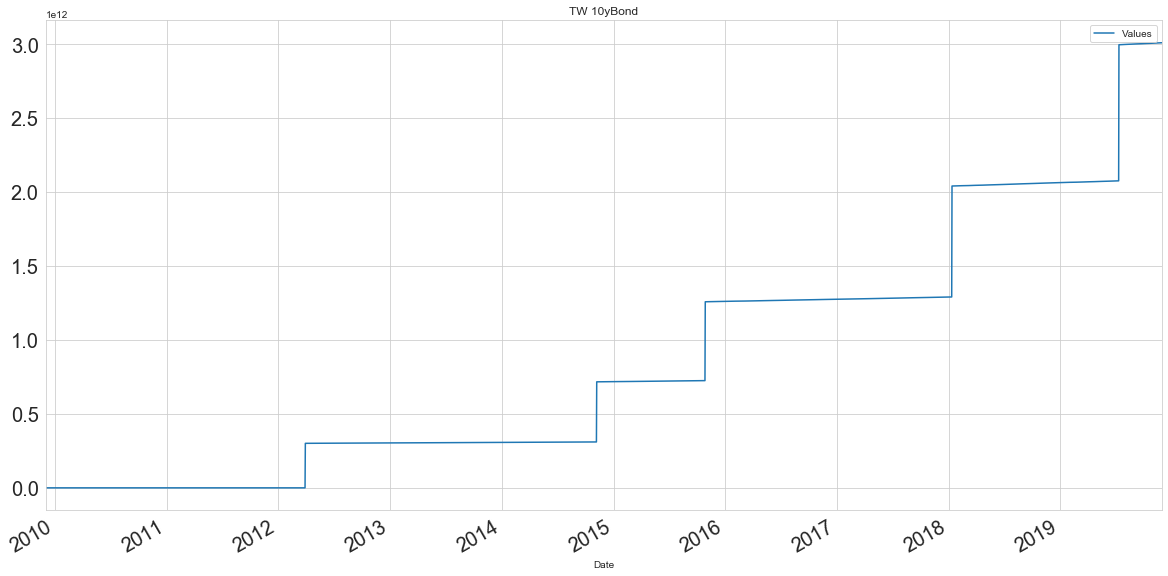

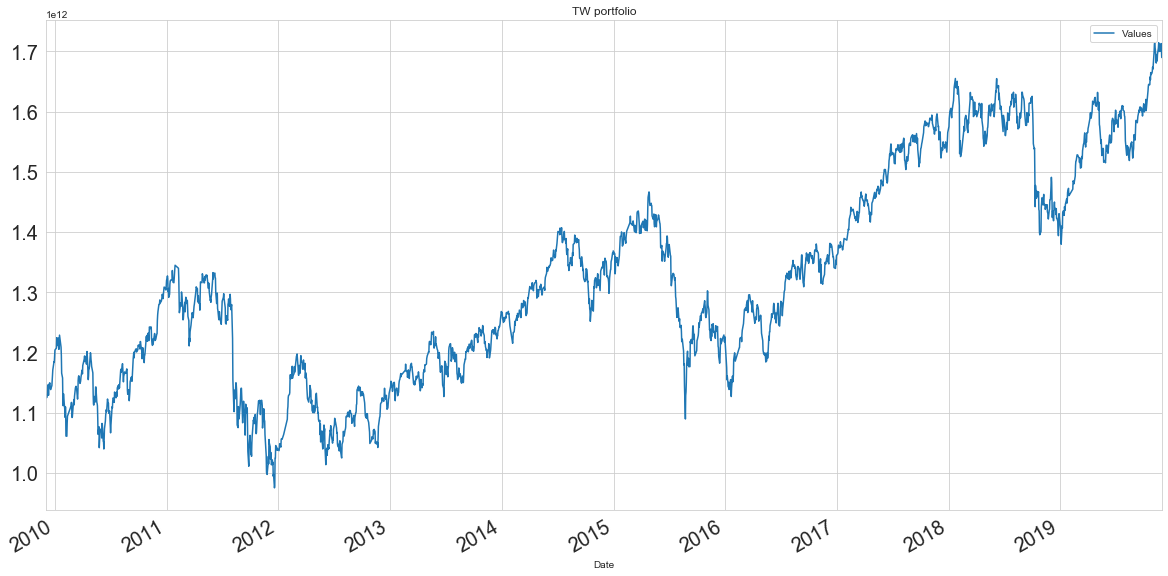

In [9]:
initial=4500000000000 ###初始資金
limit_SP=0.75  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  112027384471
最終 :  565606915698
TW_pos
初始 :  899999999999
最終 :  1351850226589
TW_bond
初始 :  0
最終 :  2440444920016
tatal
初始total :  4500000000000
最終total :  21060839889788
買進次數 :  0
賣出次數 :  4
總交易次數 :  4
tatal value 在國外投資上限 85.00000000000001 %下的表現評估 : 
annual volatility:0.15974961443928157
annual return:0.17671976024871539
sharpe ratio:1.1062296511262248
max drawdown:0.2363735880957998
max down duration:195 days


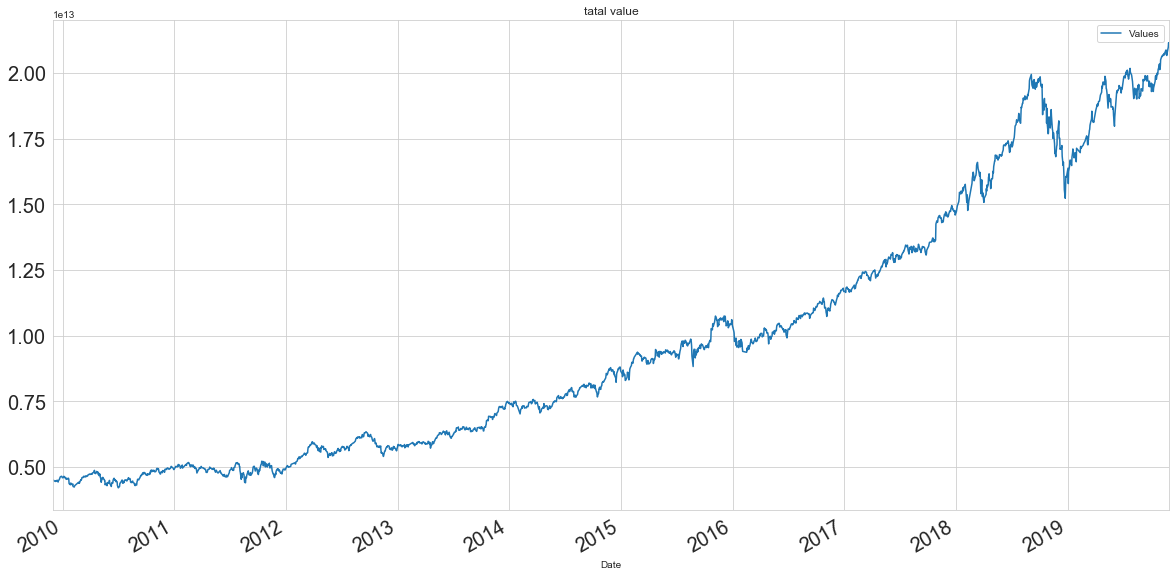

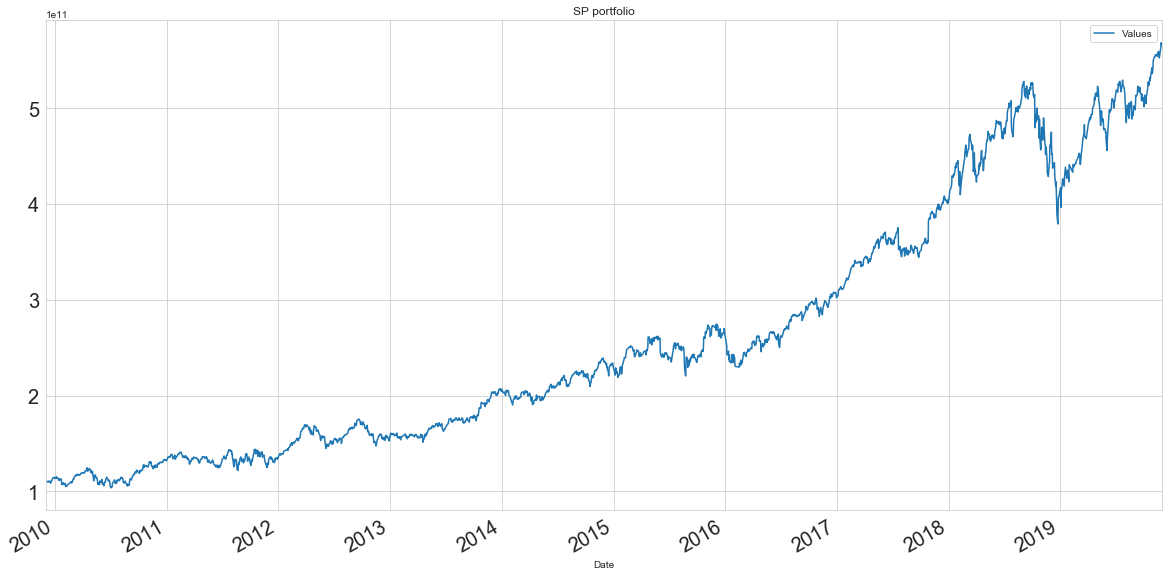

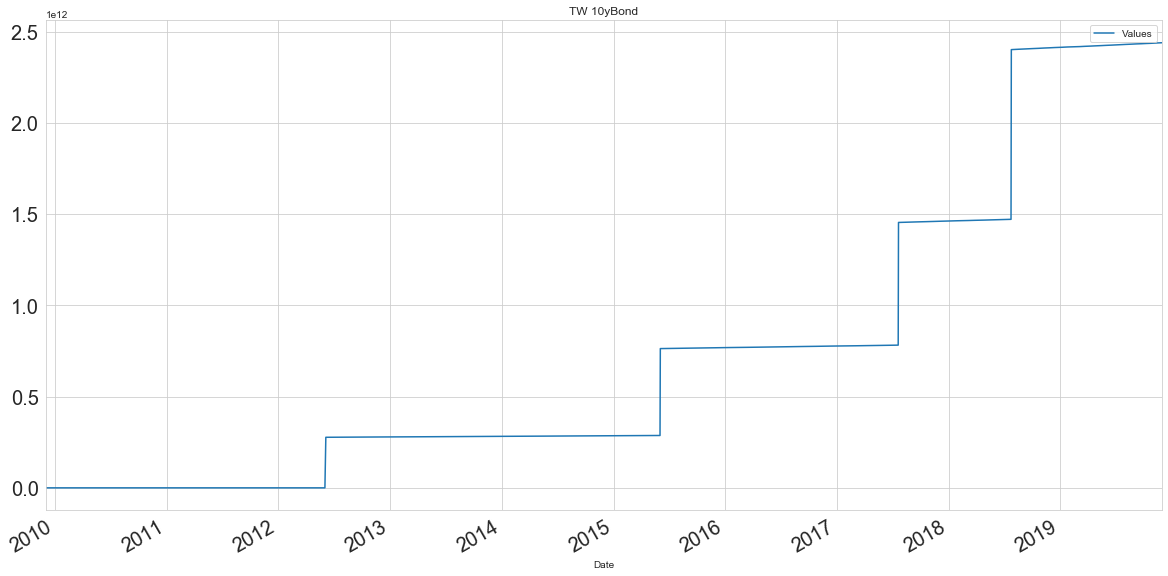

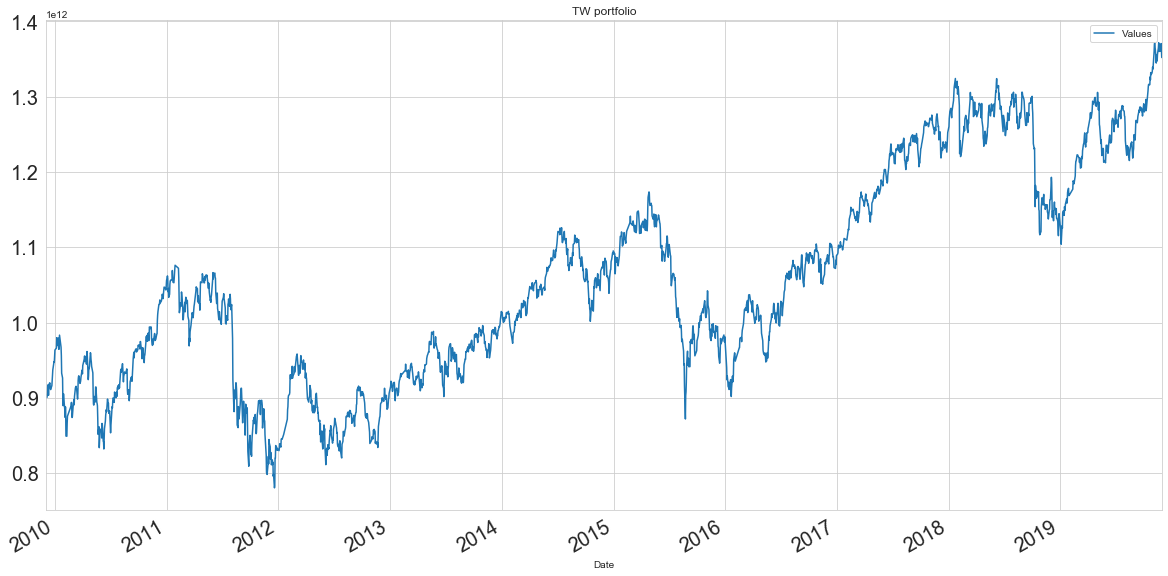

In [10]:
initial=4500000000000 ###初始資金
limit_SP=0.80  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


SP_pos
初始 :  119029096001
最終 :  639960011211
TW_pos
初始 :  675000000000
最終 :  1013887669942
TW_bond
初始 :  0
最終 :  2041113716989
tatal
初始total :  4500000000000
最終total :  22593620489231
買進次數 :  0
賣出次數 :  3
總交易次數 :  3
tatal value 在國外投資上限 90.0 %下的表現評估 : 
annual volatility:0.16862250155194505
annual return:0.1854686094742175
sharpe ratio:1.0999042699949682
max drawdown:0.2510248693647034
max down duration:195 days


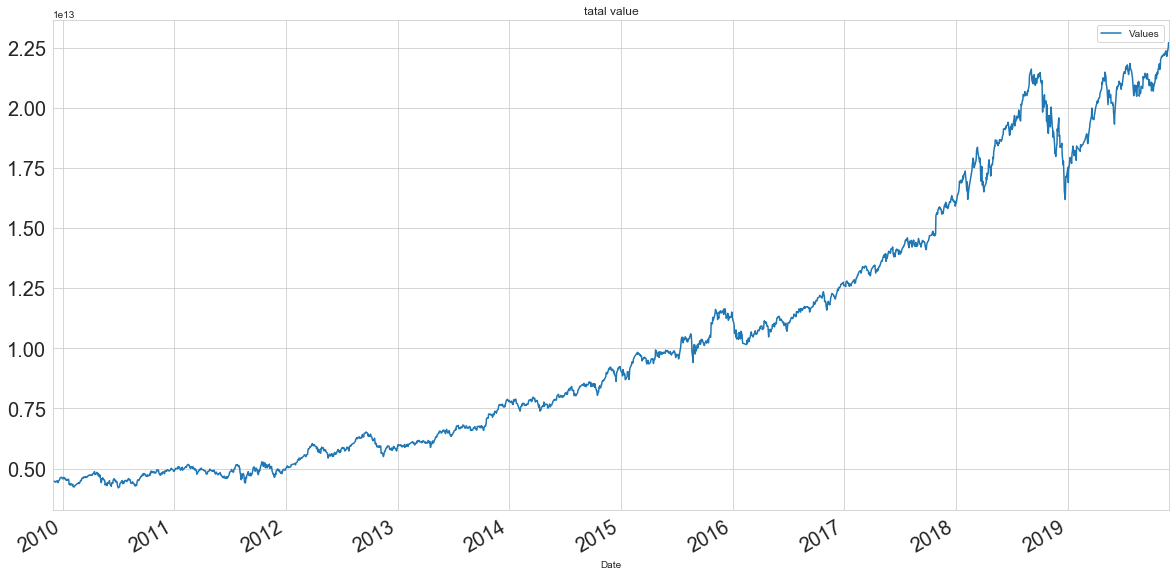

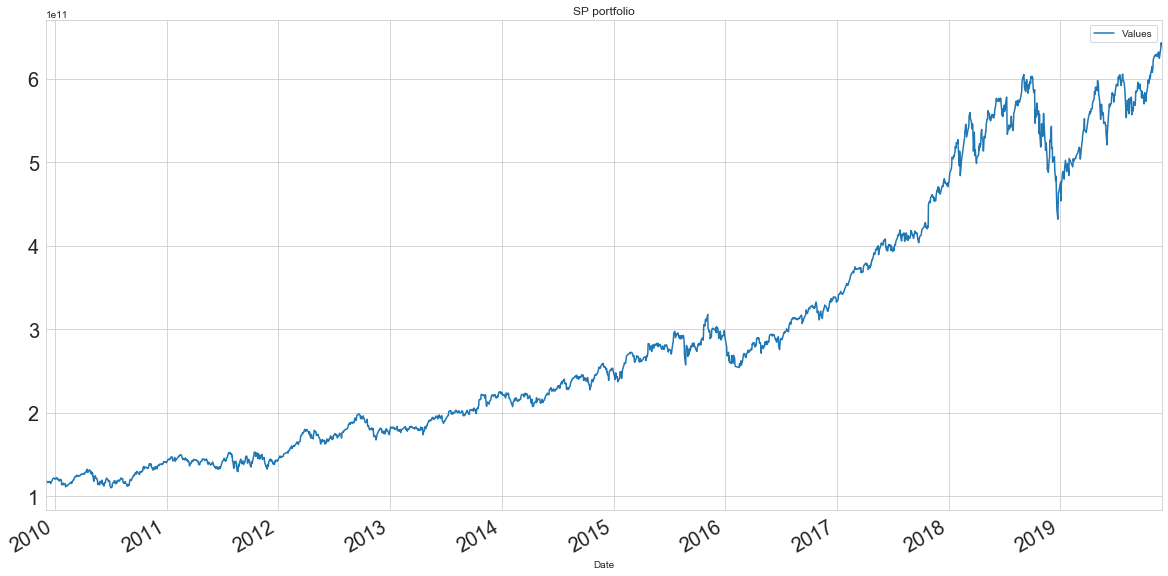

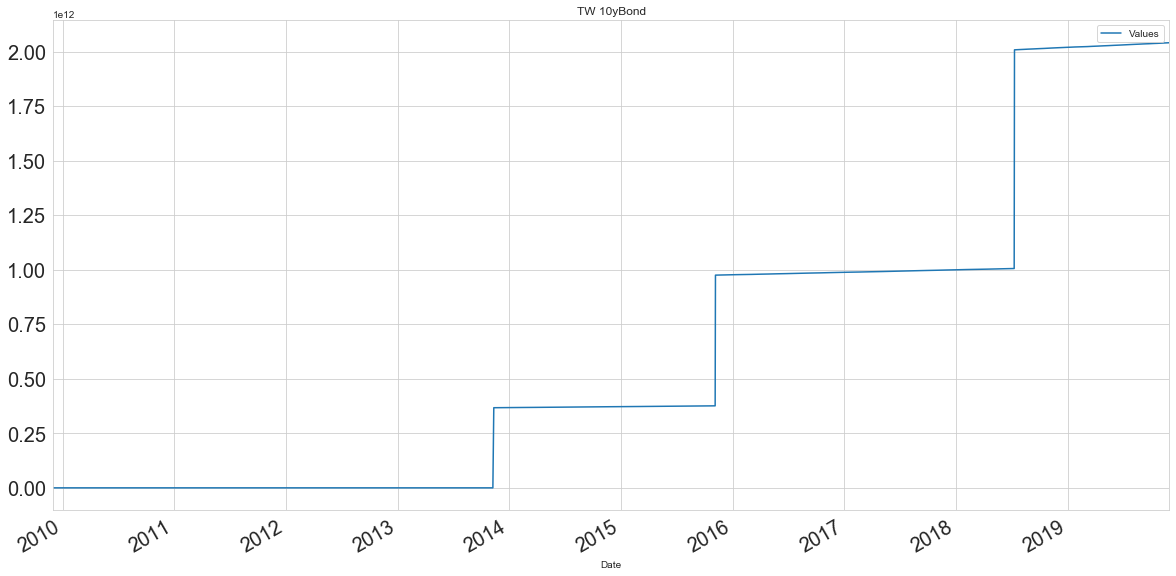

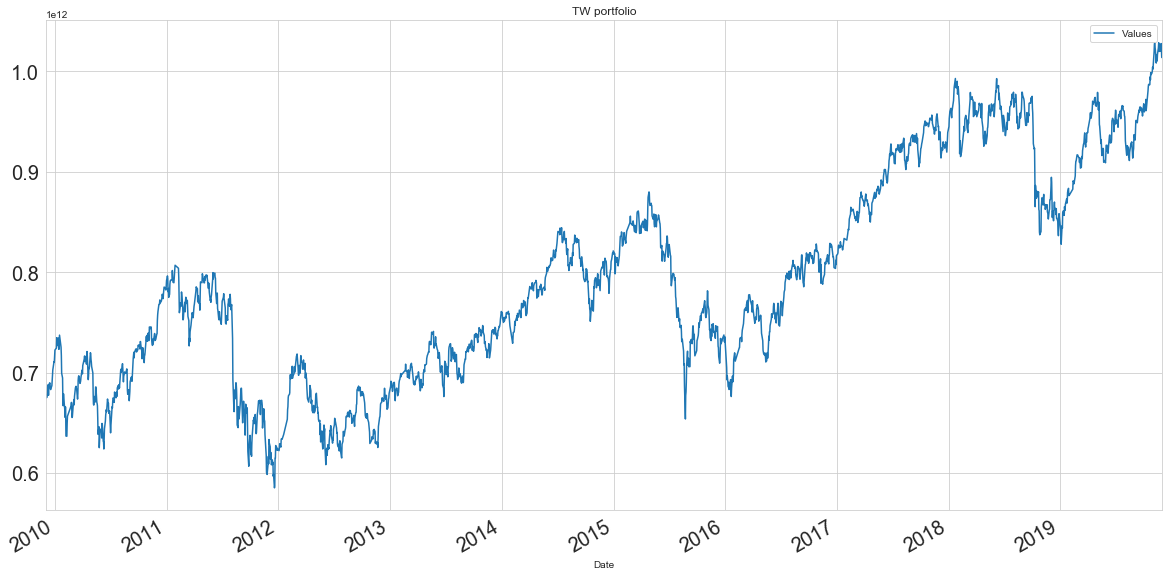

In [11]:
initial=4500000000000 ###初始資金
limit_SP=0.85  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

SP_pos
初始 :  126030807530
最終 :  772221848517
TW_pos
初始 :  449999999999
最終 :  675925113294
TW_bond
初始 :  0
最終 :  577265657915
tatal
初始total :  4500000000000
最終total :  24829896028291
買進次數 :  0
賣出次數 :  1
總交易次數 :  1
tatal value 在國外投資上限 95.0 %下的表現評估 : 
annual volatility:0.17880678483146875
annual return:0.1973247962847653
sharpe ratio:1.1035643668149975
max drawdown:0.2696059874172257
max down duration:195 days


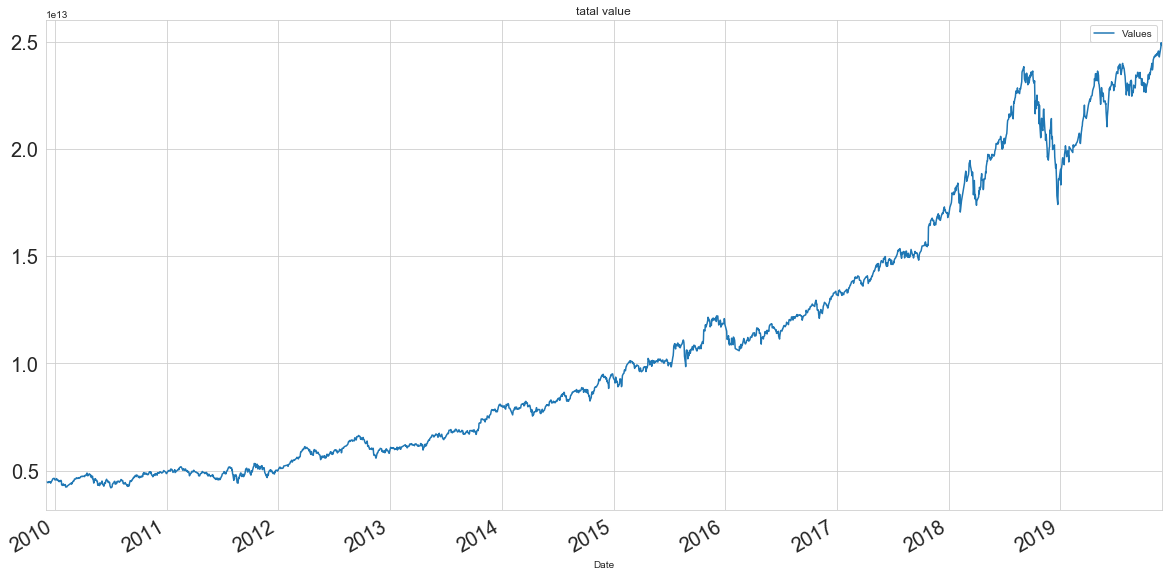

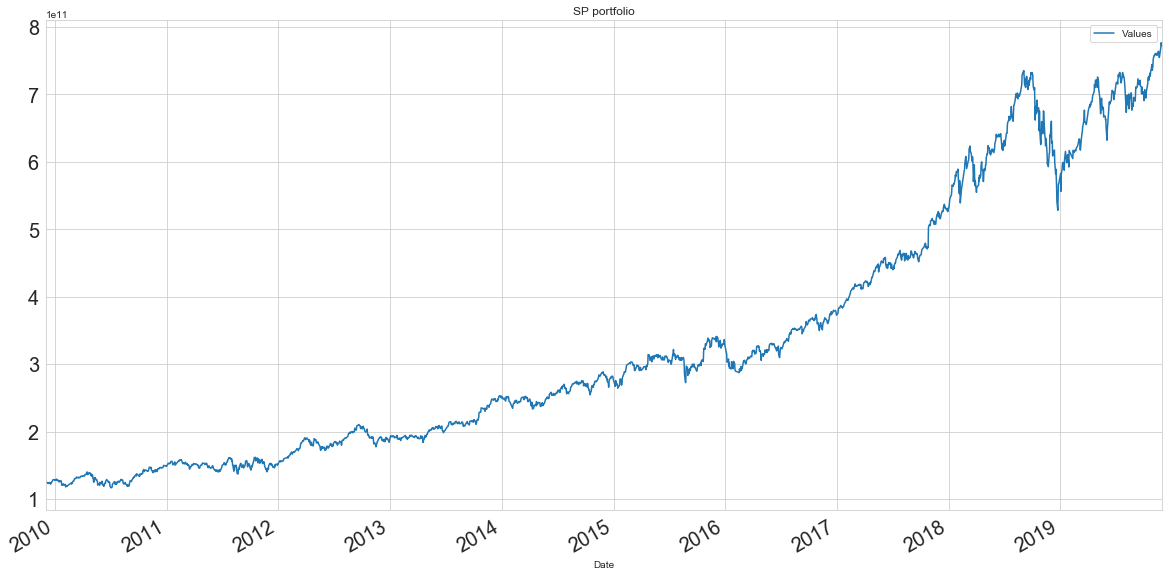

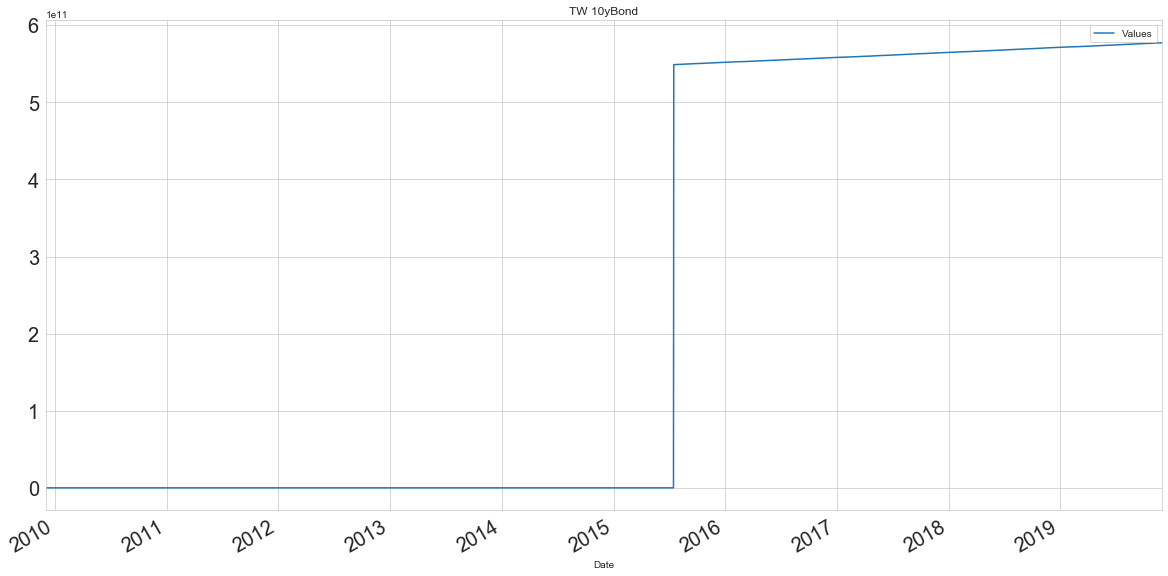

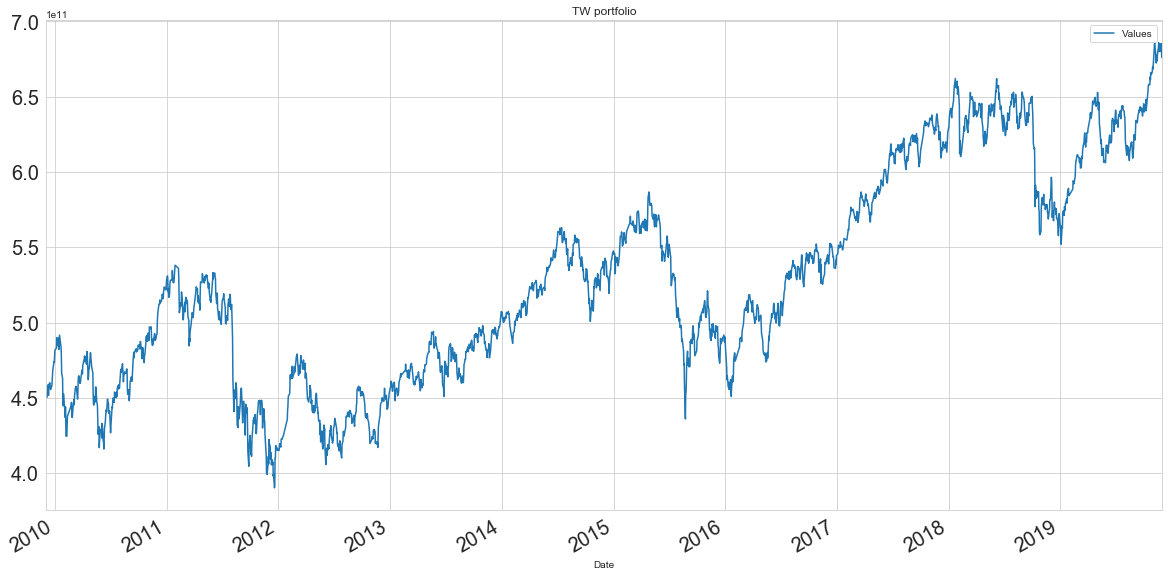

In [12]:
initial=4500000000000 ###初始資金
limit_SP=0.90  ###國外限制投資比例，5%波動範圍

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TWtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])
TWbond10y_value = pd.DataFrame(data = np.zeros((len(daily_TW), 1)), index = daily_TW.index[:], columns = ['Values'])                

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        
        if initial*(1-limit_SP)<0.1*21000000000000 :
            TWtotal_port_value.iloc[i,0]=initial*(1-limit_SP)
        else:
            TWtotal_port_value.iloc[i,0]=0.1*21000000000000 ###2009年台股市值約21兆
            
        if (initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0])>0:
            TWbond10y_value.iloc[i,0]=initial*(1-limit_SP)-TWtotal_port_value.iloc[i,0] #TW債券部位 
        else:
            TWbond10y_value.iloc[i,0]=0

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                            
        TWtotal_port_value.iloc[i,0]=TWtotal_port_value.iloc[i-1,0]*(daily_TW.iloc[i,3]/daily_TW.iloc[i-1,3])
        TWbond10y_value.iloc[i,0]=TWbond10y_value.iloc[i-1,0]*(1.012316**(1/250)) #債券部位，日複利，假設年利率=1.2316%   
        
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]+TWtotal_port_value.iloc[i,0]+TWbond10y_value.iloc[i,0]
        
        if (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) > (limit_SP+0.05): ###境外資產超過資金45%
            sell_num+=1
            need_sell=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###維持40%境外資產
            
            while (need_sell>0):
                j=-1
                high_SP =ticker_SP[0]
                H=0
                for tick in ticker_SP:###獲利最高的賣掉
                    j+=1
                    if j==0:
                        high_SP=ticker_SP[0]        
                    if (SPpos_value.iloc[i,j]/SPcost_value.iloc[i,j]) > (SPpos_value.iloc[i,j-1]/SPcost_value.iloc[i,j-1]):
                        high_SP=tick
                        H=j
                        
                if (SPpos_value.iloc[i,H]<=need_sell):###避免賣超過
                    SPcost_value.iloc[i,H]=SPpos_value.iloc[i,H]=0
                    need_sell-=SPpos_value.iloc[i,H]
                else:          
                    SPcost_value.iloc[i,H]*= 1-float(need_sell/SPpos_value.iloc[i,H])
                    SPpos_value.iloc[i,H]-=need_sell
                    need_sell=0
            
            TWbond10y_value.iloc[i,0]+=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]-TOTAL_V.iloc[i,0]*limit_SP ###再投資bond
            SPtotal_port_value.iloc[i,0]-=SPtotal_port_value.iloc[i,0]-TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP ###扣除賣掉的價值
        
        elif (SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]/TOTAL_V.iloc[i,0]) < (limit_SP-0.05): ###境外資產低過資金35%，均勻買進
            buy_num+=1
            j=0
            sum_SP=0 ###SP的資產總價值
            for tick in ticker_SP:
                SPcost_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                SPpos_value.iloc[i,j]+=(TOTAL_V.iloc[i,0]/currency.iloc[i,0]*limit_SP-SPtotal_port_value.iloc[i,0])/len(ticker_SP)
                sum_SP+=SPpos_value.iloc[i,j]
                j+=1           
            
            TWbond10y_value.iloc[i,0]-=currency.iloc[i,0]*(sum_SP-SPtotal_port_value.iloc[i,0])
            SPtotal_port_value.iloc[i,0]=sum_SP
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)
SPtotal_port_value.plot(figsize= (20, 10), title = 'SP portfolio', fontsize = 20, grid = True)
TWbond10y_value.plot(figsize= (20, 10), title = 'TW 10yBond', fontsize = 20, grid = True)
TWtotal_port_value.plot(figsize= (20, 10), title = 'TW portfolio', fontsize = 20, grid = True)

print('SP_pos')
print("初始 : ",int(SPtotal_port_value.iloc[0,0]))
print("最終 : ",int(SPtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_pos')
print("初始 : ",int(TWtotal_port_value.iloc[0,0]))
print("最終 : ",int(TWtotal_port_value.iloc[len(daily_SP)-1,0]))

print('TW_bond')
print("初始 : ",int(TWbond10y_value.iloc[0,0]))
print("最終 : ",int(TWbond10y_value.iloc[len(daily_SP)-1,0]))

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))
    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=(limit_SP+0.05)*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

tatal
初始total :  4500000000000
最終total :  27356536094188
買進次數 :  0
賣出次數 :  0
總交易次數 :  0
tatal value 在國外投資上限 100 %下的表現評估 : 
annual volatility:0.19186890037811025
annual return:0.20962172269688595
sharpe ratio:1.0925257938300097
max drawdown:0.2766321499720345
max down duration:197 days


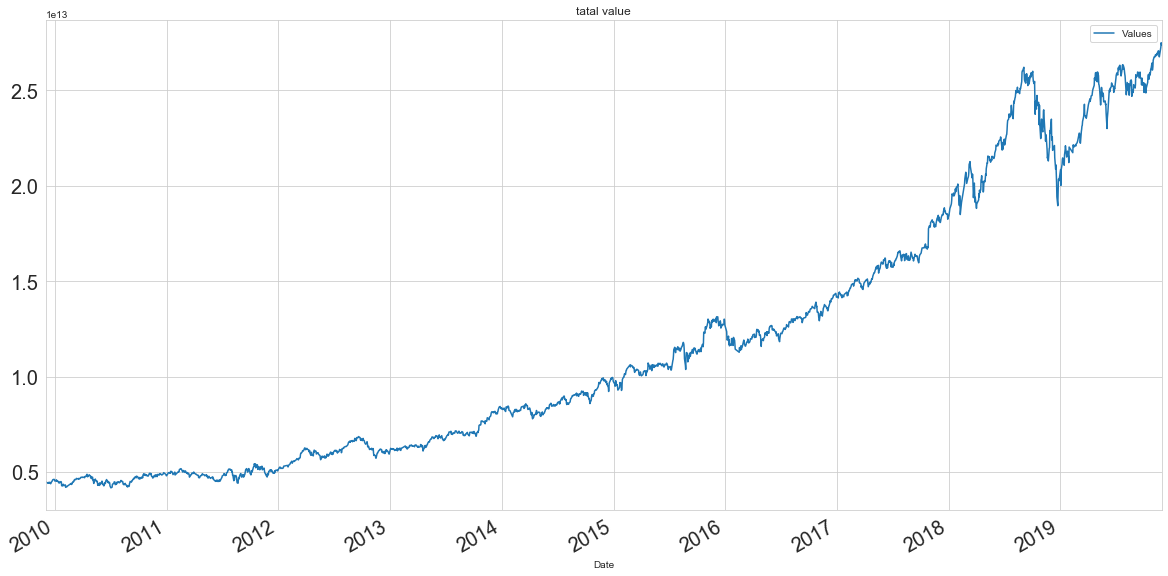

In [35]:
initial=4500000000000 ###初始資金
limit_SP=1

buy_num=0 ###交易次數
sell_num=0


#SPnum_port = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG','GOOGL','JNJ','V'])#個別資產數量
SPcost_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產成本
SPpos_value = pd.DataFrame(data = np.zeros((len(daily_SP), len(ticker_SP))), index = daily_SP.index[:], columns = ['MSFT','AAPL','AMZN','BRK-B','JPM','GOOG'])#個別資產價值
SPtotal_port_value = pd.DataFrame(data = np.zeros((len(daily_SP), 1)), index = daily_SP.index[:], columns = ['Values'])

TOTAL_V=pd.DataFrame(data = np.zeros((len(currency), 1)), index = currency.index[:], columns = ['Values'])


for i in range(0,len(daily_SP)): ###時間
    if i ==0:
        TOTAL_V.iloc[i,0]=initial ###初始金額為4.5兆
                            
        SPtotal_port_value.iloc[i,0] = initial*limit_SP/currency.iloc[i,0] ###初始金額為4.5兆*40%，保留5%波動
        j=0
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPpos_value.iloc[i,j]=SPtotal_port_value.iloc[i,0]/len(ticker_SP) #均勻買進
            j+=1
        

    else: ###更新每日資產價值
        j=0
        sum_SP=0 ###SP的資產總價值
        for tick in ticker_SP:
            SPcost_value.iloc[i,j]=SPcost_value.iloc[i-1,j]
            SPpos_value.iloc[i,j]=SPpos_value.iloc[i-1,j]*(daily_SP[tick].iloc[i,3]/daily_SP[tick].iloc[i-1,3]) 
            sum_SP+=SPpos_value.iloc[i,j]
            j+=1
                        
        SPtotal_port_value.iloc[i,0]=sum_SP
                                    
        TOTAL_V.iloc[i,0]=SPtotal_port_value.iloc[i,0]*currency.iloc[i,0]
        
            
        


###圖表
TOTAL_V.plot(figsize= (20, 10), title = 'tatal value', fontsize = 20, grid = True)

print('tatal')
print("初始total : ",int(TOTAL_V.iloc[0,0]))
print("最終total : ",int(TOTAL_V.iloc[len(daily_SP)-1,0]))

    
###表現評估 
print("買進次數 : " ,buy_num)
print("賣出次數 : " ,sell_num)
print("總交易次數 : " ,buy_num+sell_num)

limit=limit_SP*100
print("tatal value 在國外投資上限",limit,"%下的表現評估 : ")
performance_matrics(TOTAL_V)
        

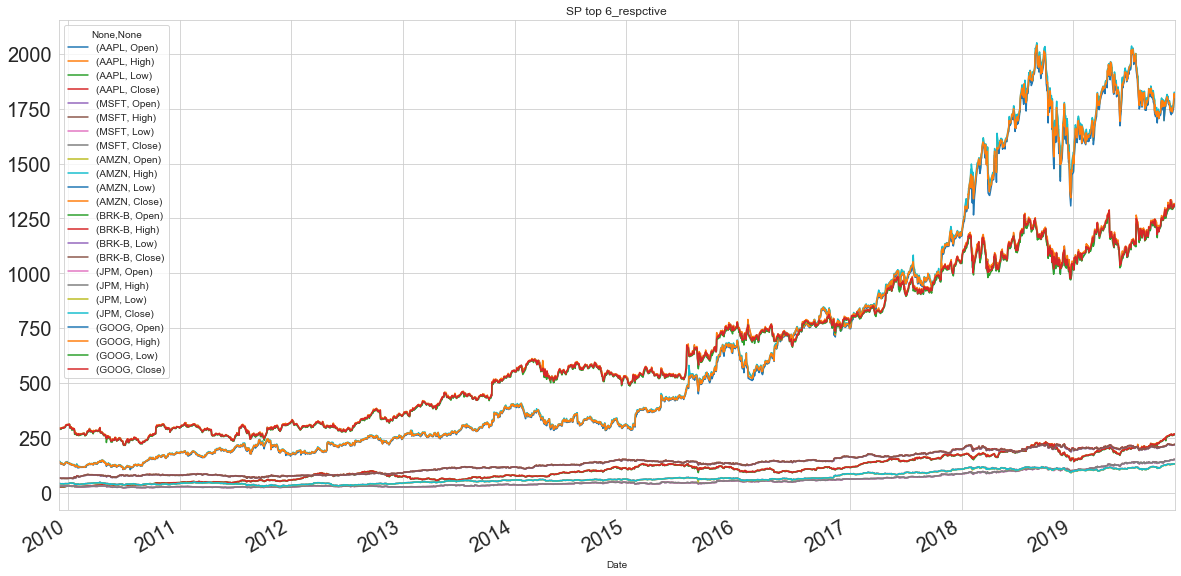

In [36]:
daily_SP.plot(figsize= (20, 10), title = 'SP top 6_respctive', fontsize = 20, grid = True)

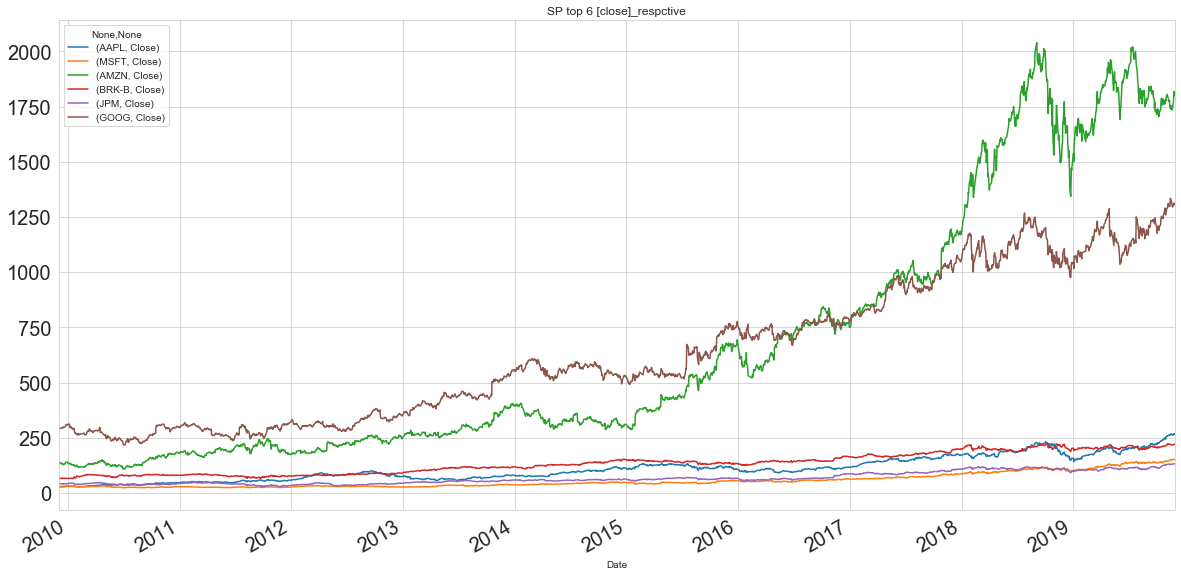

In [37]:
daily_SP_close = pd.read_excel('s_ptop6_close_stock.xlsx', index_col = 0, header = [0, 1]) ###讀資料
daily_SP_close.plot(figsize= (20, 10), title = 'SP top 6 [close]_respctive', fontsize = 20, grid = True)